In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
plt.rc('font', family='NanumBarunGothic')
# 마이너스 기호 깨짐 현상 해결
mpl.rcParams['axes.unicode_minus'] = False 
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_curve, auc
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from itertools import product
from sklearn.metrics import r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ML/airbnbmark1.csv')
data = data.loc[:,['accommodates',
'amenities',
'availability_30',
'availability_365',
'bed_type',
'bedrooms',
'beds',
'calculated_host_listings_count',
'cancellation_policy',
'cleaning_fee',
'extra_people',
'host_identity_verified',
'host_is_superhost',
'host_response_time',
'is_location_exact',
'last_review',
'last_scraped',
'number_of_reviews_ltm',
'price',
'property_type',
'review_scores_rating',
'reviews_per_month',
'room_type',
'security_deposit',
'neighbourhood_group_cleansed',
'neighbourhood_cleansed']]

In [ ]:
subway = pd.read_csv('/content/drive/MyDrive/ML/near_sub.csv')
data['near_sub'] = subway['near_sub']
data

accommodates  ... near_sub
0                  1  ...        4
1                  3  ...        1
2                  2  ...        1
3                  2  ...        1
4                  2  ...        3
...              ...  ...      ...
153249             2  ...        1
153250             2  ...        0
153251             2  ...        3
153252             2  ...        1
153253             5  ...        0

[153254 rows x 27 columns]

In [ ]:
crime = pd.read_excel('/content/drive/MyDrive/ML/NY_crime.xls')
crime

neighbourhood_cleansed  precinct  Crime_rate
0        Battery Park City         1      4.5132
1             Civic Center         1      4.5132
2       Financial District         1      4.5132
3                     SoHo         1      4.5132
4                  Tribeca         1      4.5132
..                     ...       ...         ...
220               Huguenot       123      0.7447
221           Prince's Bay       123      0.7447
222              Rossville       123      0.7447
223            Tottenville       123      0.7447
224                Woodrow       123      0.7447

[225 rows x 3 columns]

In [ ]:
data = pd.merge(data, crime)
data.drop(['neighbourhood_cleansed','precinct'], axis=1, inplace=True)

In [ ]:
# 날짜형으로 바꾸기
lst = ['last_review','last_scraped']
for i in lst :
    data[i] = pd.to_datetime(data[i], format = '%Y-%m-%d')

In [ ]:
# price object형 float로 바꾸기($n->n)
data['price']= data['price'].str.split('$').str.get(1)
data['price'] = data['price'].str.replace(',','').astype('float')

data['cleaning_fee']= data['cleaning_fee'].str.split('$').str.get(1)
data['cleaning_fee'] = data['cleaning_fee'].str.replace(',','').astype('float')

data['extra_people']= data['extra_people'].str.split('$').str.get(1)
data['extra_people'] = data['extra_people'].str.replace(',','').astype('float')

data['security_deposit']= data['security_deposit'].str.split('$').str.get(1)
data['security_deposit'] = data['security_deposit'].str.replace(',','').astype('float')

In [ ]:
# fill missing values

# median 대체
rep_med = ['bedrooms', 'beds']
for i in rep_med :
    data[i].fillna(data[i].median(), inplace=True)

# 최빈값 대체
rep_mode = ['host_identity_verified','host_is_superhost']
for i in rep_mode :
    data[i].fillna(data[i].value_counts().idxmax(), inplace=True)
    
# reviews_per_month missing value는 number_of_reviews = 0 인 경우이므로 0으로 대체
data['reviews_per_month'].fillna(0, inplace=True)

# host_response_time는 응답을 안한것으로 간주, 가장 큰 penalty를 줄 수 있는 변수로 대체
data['host_response_time'].fillna('a few days or more', inplace=True)

In [ ]:
# amenities column 만들기
# amenities columns는 추후 모델링 시 column 하나 제거하는 과정 X
items = ['24-hour','Bathtub', 'Breakfast', 'Pool', 'Private entrance', 'Private living room', 
         'Gym', 'Kitchen', 'Lock on bedroom door', 'Garden or backyard']
for i in items : 
    if '24' in i :
        s = 'amenities_24h'
    elif 'entrance' in i :
        s = 'amenities_pent'
    elif 'living' in i :
        s = 'amenities_pliv'
    elif 'Lock' in i :
        s = 'amenities_lock'
    elif 'Garden' in i :
        s = 'amenities_garden'
    else :
        s = 'amenities_'+i.lower() 
    data[s] = np.where(data['amenities'].str.contains(i), 1, 0 )
data['amenities_dw'] = np.where((data['amenities'].str.contains('Dryer','Washer')) | (data['amenities'].str.contains('Washer')), 1, 0)
data['amenities_TV'] = np.where(data['amenities'].str.replace('Cable TV','').str.contains('TV'), 1, 0)

data.drop('amenities', axis=1, inplace=True)

In [ ]:
# make derived variable

# review_updated = last_scraped - last_review (missing value는 max로 대체해 penalty 부과)
temp = (data[data['last_review'].notnull()]['last_scraped']-data[data['last_review'].notnull()]['last_review']).astype('str').str.split('days').str.get(0).astype('int')
max_temp = temp.max()
# max_temp = 4191
data['review_updated'] = (data['last_scraped']-data['last_review']).astype('str').str.split('days').str.get(0)
data['review_updated'] = data['review_updated'].str.replace('NaT',str(max_temp)).astype('float')

# beds_per_accom = bedrooms/accommodates 
# 침대 하나가 차지하는 방의 공간(개인이 사용할 수 있는 공간의 크기로 간주)
data['beds_per_accom'] = data['beds']/data['accommodates']

del temp, max_temp

In [ ]:
data.drop(['last_review','last_scraped','beds','accommodates'], axis=1, inplace=True)

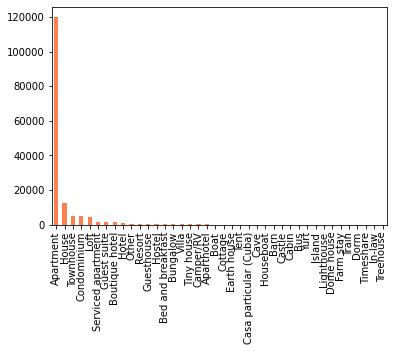

In [ ]:
data['property_type'].value_counts().plot.bar(color = 'coral')

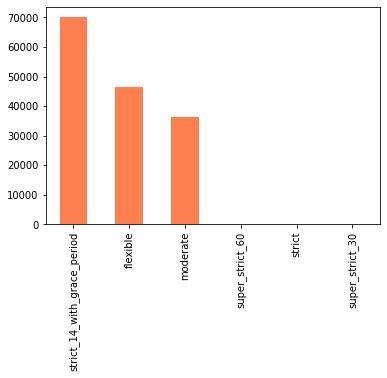

In [ ]:
data['cancellation_policy'].value_counts().plot.bar(color = 'coral')

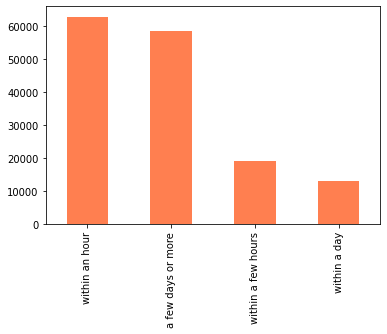

In [ ]:
data['host_response_time'].value_counts().plot.bar(color = 'coral')

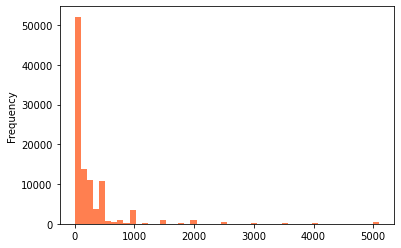

In [ ]:
data['security_deposit'].plot.hist(bins=50, color = 'coral')

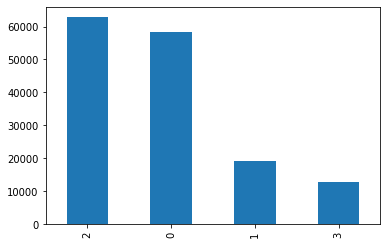

In [ ]:
# categorize 

# property_type(bph = basic_privacy_high, bpl = basic_privacy_low, se = special experience)
types = {'housing' : ['Apartment','House','Loft','Serviced apartment','Townhouse','Villa'],
         
        'bph' : ['Aparthotel','Bed and breakfast','Boutique hotel','Casa particular (Cuba)',
                      'Condominium','Guest suite','Guesthouse','Hotel','Resort','Timeshare'],
        'bpl' : ['Dorm', 'Hostel'],
        'se' : ['Barn','Boat','Bungalow','Bus','Cabin','Camper/RV',
                              'Castle','Cave','Cottage','Dome house','Earth house','Farm stay',
                              'Houseboat','Island','Lighthouse','Tent','Tiny house','Train','Treehouse','Yurt'],
        'other' : ['In-law','Other']}

for k in types.keys() :
    for v in types[k] :
        data['property_type'] = np.where(data['property_type']==v, k, data['property_type'])
    
                    
# cancellation_policy flexible, moderate, strict
data['cancellation_policy'] = np.where(data['cancellation_policy'].str.contains('strict'), 'strict', data['cancellation_policy'])


# security_deposit 없으면 0, 있으면 1
data['security_deposit'] = np.where(data['security_deposit'] > 0, 1, data['security_deposit'])

# host_response_time ordinal로 변경
# within a day : 3, within an hour : 2, wihthin a few hours : 1, a few days or more : 0
dic = {'within a day' : 3, 'within an hour' : 2, 'within a few hours' : 1, 'a few days or more' : 0}
for i in dic :
    data['host_response_time'] = data['host_response_time'].str.replace(i, str(dic[i]))
data['host_response_time'] = data['host_response_time'].astype('int')
data['host_response_time'].value_counts().plot.bar()

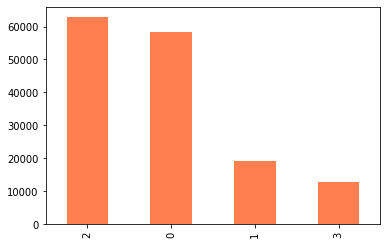

In [ ]:
data['host_response_time'].value_counts().plot.bar(color = 'coral')

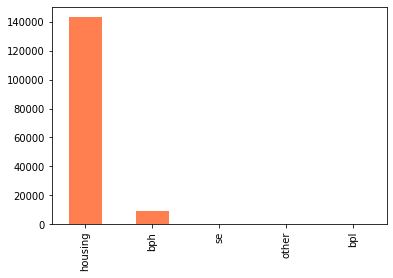

In [ ]:
data['property_type'].value_counts().plot.bar(color = 'coral')

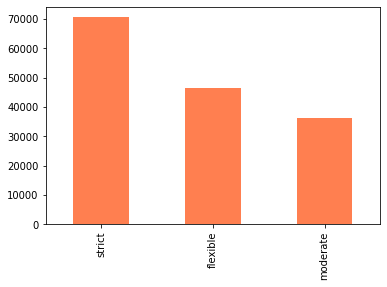

In [ ]:
data['cancellation_policy'].value_counts().plot.bar(color = 'coral')

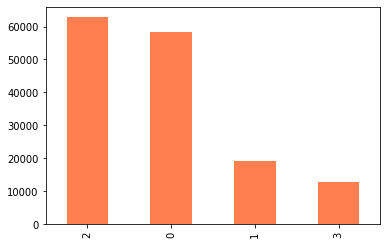

In [ ]:
data['host_response_time'].value_counts().plot.bar(color = 'coral')

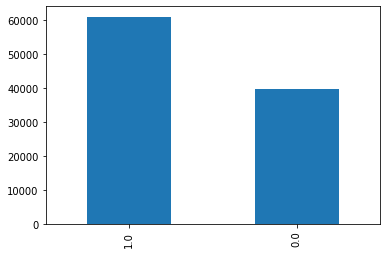

In [ ]:
data['security_deposit'].value_counts().plot.bar()

In [ ]:
data.isnull().sum()

availability_30                       0
availability_365                      0
bed_type                              0
bedrooms                              0
calculated_host_listings_count        0
cancellation_policy                   0
cleaning_fee                      31923
extra_people                          0
host_identity_verified                0
host_is_superhost                     0
host_response_time                    0
is_location_exact                     0
number_of_reviews_ltm                 0
price                                 0
property_type                         0
review_scores_rating              33881
reviews_per_month                     0
room_type                             0
security_deposit                  52623
neighbourhood_group_cleansed          0
near_sub                              0
Crime_rate                            0
amenities_24h                         0
amenities_bathtub                     0
amenities_breakfast                   0


In [ ]:
data

availability_30  availability_365  ... review_updated  beds_per_accom
0                    30               365  ...          100.0        1.000000
1                     0                42  ...         1500.0        0.250000
2                    30               180  ...          288.0        0.333333
3                    11               125  ...           93.0        1.000000
4                    20                86  ...            3.0        0.500000
...                 ...               ...  ...            ...             ...
153249                2                15  ...            1.0        0.666667
153250               15               250  ...            8.0        0.250000
153251               11               155  ...           17.0        0.666667
153252                7               131  ...            6.0        0.555556
153253                0                 8  ...          236.0        0.500000

[153254 rows x 36 columns]

In [ ]:
data.isnull().sum()

availability_30                       0
availability_365                      0
bed_type                              0
bedrooms                              0
calculated_host_listings_count        0
cancellation_policy                   0
cleaning_fee                      31923
extra_people                          0
host_identity_verified                0
host_is_superhost                     0
host_response_time                    0
is_location_exact                     0
number_of_reviews_ltm                 0
price                                 0
property_type                         0
review_scores_rating              33881
reviews_per_month                     0
room_type                             0
security_deposit                  52623
neighbourhood_group_cleansed          0
near_sub                              0
Crime_rate                            0
amenities_24h                         0
amenities_bathtub                     0
amenities_breakfast                   0


## missing value imputation using clustering 


In [ ]:
from copy import deepcopy
df = deepcopy(data)
df.dtypes

availability_30                     int64
availability_365                    int64
bed_type                           object
bedrooms                          float64
calculated_host_listings_count      int64
cancellation_policy                object
cleaning_fee                      float64
extra_people                      float64
host_identity_verified             object
host_is_superhost                  object
host_response_time                  int64
is_location_exact                  object
number_of_reviews_ltm               int64
price                             float64
property_type                      object
review_scores_rating              float64
reviews_per_month                 float64
room_type                          object
security_deposit                  float64
neighbourhood_group_cleansed       object
near_sub                            int64
Crime_rate                        float64
amenities_24h                       int64
amenities_bathtub                 

In [ ]:
df.drop(['cleaning_fee','security_deposit','price','review_scores_rating'], axis=1, inplace=True)

In [ ]:
num_cols = list(df.describe().columns)
for i in df.columns :
    if ('amenities' in i) :
        num_cols.remove(i)

In [ ]:
num_cols

['availability_30',
 'availability_365',
 'bedrooms',
 'calculated_host_listings_count',
 'extra_people',
 'host_response_time',
 'number_of_reviews_ltm',
 'reviews_per_month',
 'near_sub',
 'Crime_rate',
 'review_updated',
 'beds_per_accom']

In [ ]:
df_dummy =pd.get_dummies(df, drop_first=True)
df_dummy

availability_30  ...  neighbourhood_group_cleansed_Staten Island
0                    30  ...                                           0
1                     0  ...                                           0
2                    30  ...                                           0
3                    11  ...                                           0
4                    20  ...                                           0
...                 ...  ...                                         ...
153249                2  ...                                           1
153250               15  ...                                           1
153251               11  ...                                           1
153252                7  ...                                           1
153253                0  ...                                           0

[153254 rows x 44 columns]

In [ ]:
dum_cols = list(set(df_dummy.columns) - set(num_cols))
dum_cols

['property_type_se',
 'host_is_superhost_t',
 'room_type_Private room',
 'property_type_housing',
 'neighbourhood_group_cleansed_Staten Island',
 'neighbourhood_group_cleansed_Brooklyn',
 'cancellation_policy_moderate',
 'amenities_24h',
 'neighbourhood_group_cleansed_Manhattan',
 'amenities_gym',
 'amenities_TV',
 'bed_type_Real Bed',
 'amenities_bathtub',
 'amenities_dw',
 'bed_type_Futon',
 'amenities_kitchen',
 'amenities_breakfast',
 'room_type_Hotel room',
 'amenities_garden',
 'property_type_bpl',
 'room_type_Shared room',
 'amenities_pliv',
 'cancellation_policy_strict',
 'neighbourhood_group_cleansed_Queens',
 'host_identity_verified_t',
 'property_type_other',
 'amenities_pool',
 'amenities_lock',
 'bed_type_Pull-out Sofa',
 'is_location_exact_t',
 'amenities_pent',
 'bed_type_Couch']

In [ ]:
scaler_df = preprocessing.StandardScaler()
df_scaled = scaler_df.fit_transform(df_dummy[num_cols])
df_scaled = pd.DataFrame(df_scaled, columns=num_cols, index=df.index)
df_scaled[dum_cols] = df_dummy[dum_cols]
df_scaled

availability_30  availability_365  ...  amenities_pent  bed_type_Couch
0              1.587244          1.805629  ...               0               0
1             -0.879501         -0.566869  ...               0               0
2              1.587244          0.446768  ...               0               0
3              0.024972          0.042783  ...               0               0
4              0.764996         -0.243680  ...               0               0
...                 ...               ...  ...             ...             ...
153249        -0.715052         -0.765189  ...               1               0
153250         0.353872          0.960932  ...               1               0
153251         0.024972          0.263138  ...               1               0
153252        -0.303927          0.086854  ...               1               0
153253        -0.879501         -0.816605  ...               0               0

[153254 rows x 44 columns]

In [ ]:
from sklearn.cluster import KMeans
clus_error=[]
cluster_range = [i for i in range(1,10)]
for v_n_clus in cluster_range :
    clus = KMeans(v_n_clus, random_state=1234)
    clus.fit(df_scaled)
    clus_error.append(clus.inertia_)
ds_error=pd.DataFrame({'NumberofCluster' : cluster_range, 'Error':clus_error})
ds_error

NumberofCluster         Error
0                1  2.363851e+06
1                2  2.047299e+06
2                3  1.882828e+06
3                4  1.747267e+06
4                5  1.623804e+06
5                6  1.543399e+06
6                7  1.478779e+06
7                8  1.423938e+06
8                9  1.373356e+06

Text(0, 0.5, 'Sum of squared distance')

findfont: Font family ['MalgunGodic'] not found. Falling back to DejaVu Sans.


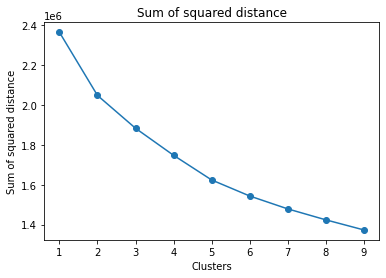

In [ ]:
plt.plot(ds_error['NumberofCluster'],ds_error['Error'], marker='o')
plt.title('Sum of squared distance')
plt.xlabel('Clusters')
plt.ylabel('Sum of squared distance')

In [ ]:
ds_error['diff'] = ds_error['Error'].diff()
ds_error['rate'] = abs(ds_error['diff']*100/ds_error['Error'])
ds_error

NumberofCluster         Error           diff       rate
0                1  2.363851e+06            NaN        NaN
1                2  2.047299e+06 -316552.356474  15.461951
2                3  1.882828e+06 -164471.401045   8.735341
3                4  1.747267e+06 -135560.431113   7.758426
4                5  1.623804e+06 -123463.292628   7.603338
5                6  1.543399e+06  -80404.650949   5.209582
6                7  1.478779e+06  -64619.970947   4.369819
7                8  1.423938e+06  -54841.203604   3.851376
8                9  1.373356e+06  -50582.104592   3.683102

Text(0, 0.5, 'Sum of squared distance decreasing rate')

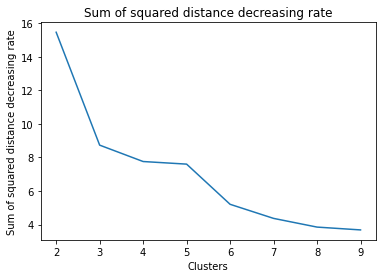

In [ ]:
plt.plot(ds_error['NumberofCluster'],ds_error['rate'])
plt.title('Sum of squared distance decreasing rate')
plt.xlabel('Clusters')
plt.ylabel('Sum of squared distance decreasing rate')

In [ ]:
clus = KMeans(4, random_state = 1234)
model_fit=clus.fit(df_scaled)
cluster_kmeans =[i for i in clus.labels_]
data['ClusterKmeans']=cluster_kmeans
data

availability_30  availability_365  ... beds_per_accom  ClusterKmeans
0                    30               365  ...       1.000000              3
1                     0                42  ...       0.250000              3
2                    30               180  ...       0.333333              3
3                    11               125  ...       1.000000              3
4                    20                86  ...       0.500000              3
...                 ...               ...  ...            ...            ...
153249                2                15  ...       0.666667              2
153250               15               250  ...       0.250000              1
153251               11               155  ...       0.666667              1
153252                7               131  ...       0.555556              1
153253                0                 8  ...       0.500000              2

[153254 rows x 37 columns]

In [ ]:
values = data.groupby('ClusterKmeans').mean().loc[:,['cleaning_fee','review_scores_rating']]
values

cleaning_fee  review_scores_rating
ClusterKmeans                                    
0                 57.947604             94.756744
1                 77.378962             92.847374
2                 59.098532             94.333388
3                127.882444             92.597549

In [ ]:
# security_deposit은 binary이므로 원래 데이터의 0의 비율보다 0의 비율이 큰 군집은 0, 작은 군집은 1로 대체
temp = pd.crosstab(data['ClusterKmeans'],data['security_deposit'])
temp['r'] = temp[0]/(temp[1]+temp[0])
temp['origin'] = data['security_deposit'].value_counts()[0]/(data['security_deposit'].value_counts()[1]+data['security_deposit'].value_counts()[0])
temp

security_deposit    0.0    1.0         r    origin
ClusterKmeans                                     
0                  9526  11417  0.454854  0.393855
1                 14140  22756  0.383239  0.393855
2                 14599  23718  0.381006  0.393855
3                  1369   3106  0.305922  0.393855

In [ ]:
values['security_deposit'] = np.where(temp['r']>temp['origin'], 0, 1)
values

cleaning_fee  review_scores_rating  security_deposit
ClusterKmeans                                                      
0                 57.947604             94.756744                 0
1                 77.378962             92.847374                 1
2                 59.098532             94.333388                 1
3                127.882444             92.597549                 1

In [ ]:
for i in range(0,4) :
    for j in values.columns :
        data[j] = np.where((data[j].isnull()==True) & (data['ClusterKmeans']==i), values.iloc[i][j], data[j])

In [ ]:
data.isnull().sum()

availability_30                   0
availability_365                  0
bed_type                          0
bedrooms                          0
calculated_host_listings_count    0
cancellation_policy               0
cleaning_fee                      0
extra_people                      0
host_identity_verified            0
host_is_superhost                 0
host_response_time                0
is_location_exact                 0
number_of_reviews_ltm             0
price                             0
property_type                     0
review_scores_rating              0
reviews_per_month                 0
room_type                         0
security_deposit                  0
neighbourhood_group_cleansed      0
near_sub                          0
Crime_rate                        0
amenities_24h                     0
amenities_bathtub                 0
amenities_breakfast               0
amenities_pool                    0
amenities_pent                    0
amenities_pliv              

In [ ]:
data.drop('ClusterKmeans', axis=1, inplace=True)

In [ ]:
data.to_csv('/content/drive/MyDrive/ML/airbnb_preprocessed(updated).csv', index=False, encoding='utf-8')

# EDA

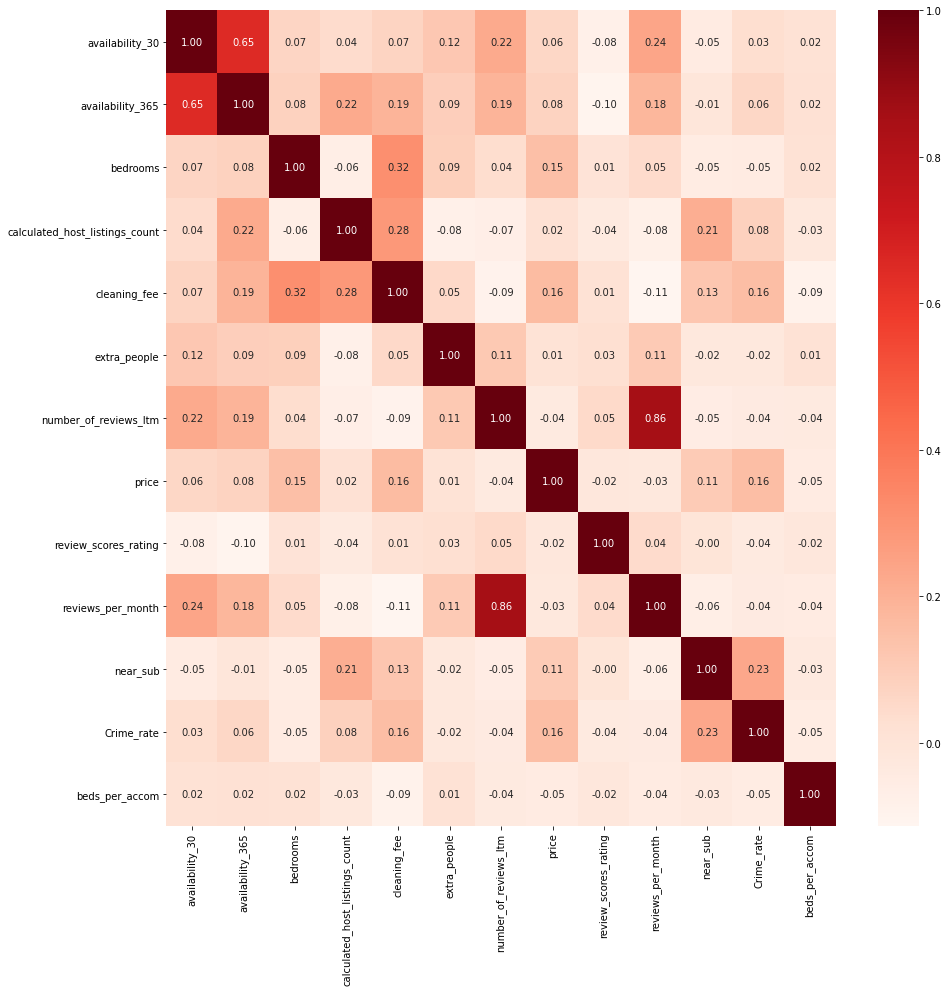

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(data.loc[:,['availability_30', 'availability_365','bedrooms','calculated_host_listings_count','cleaning_fee','extra_people','number_of_reviews_ltm','price','review_scores_rating','reviews_per_month','near_sub','Crime_rate','beds_per_accom']].corr(), fmt = '.2f', cmap = 'Reds',annot=True)

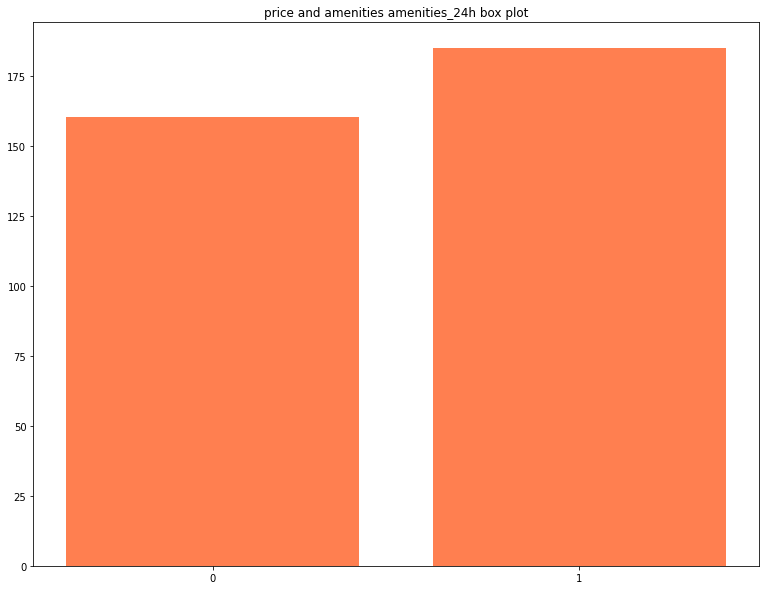

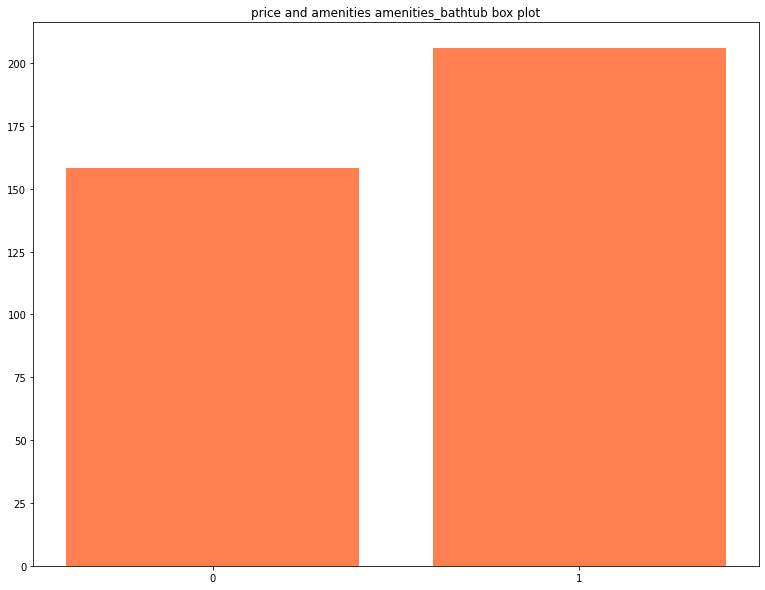

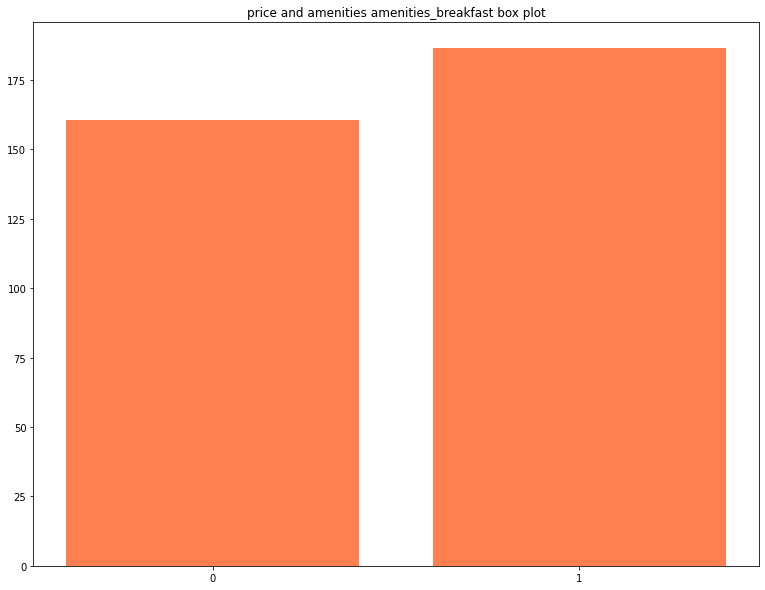

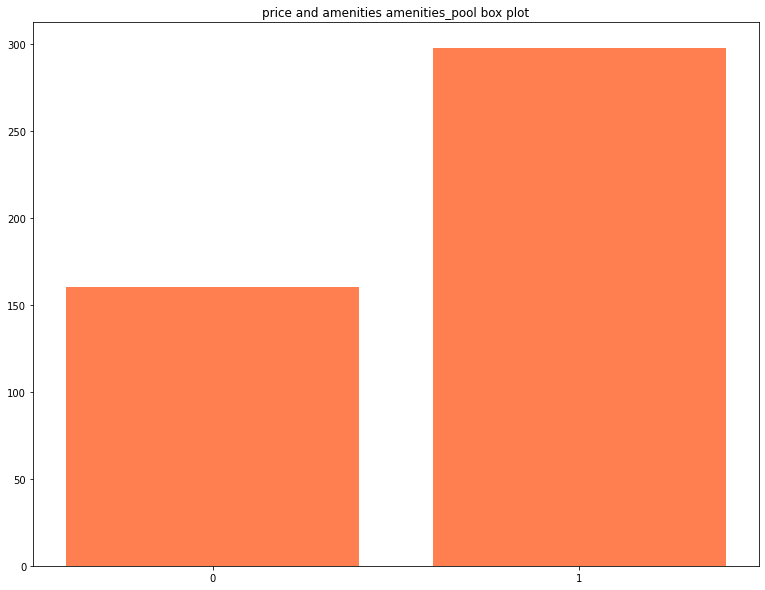

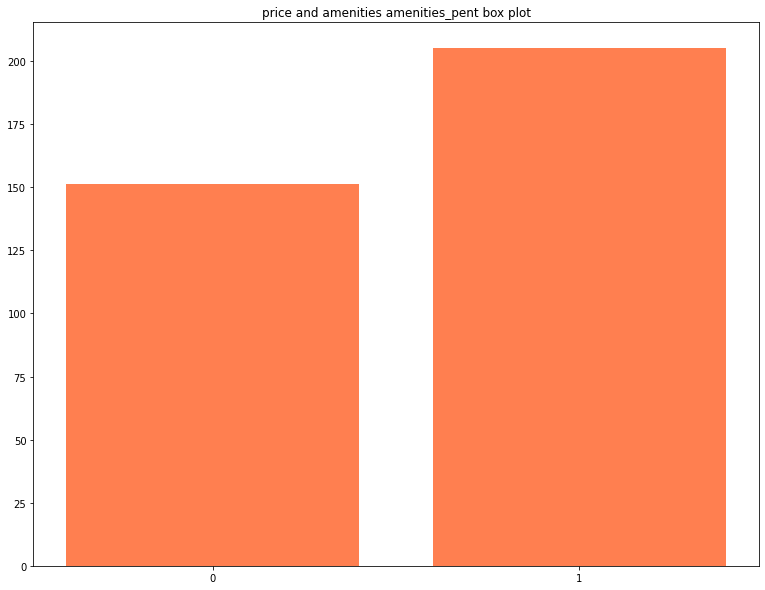

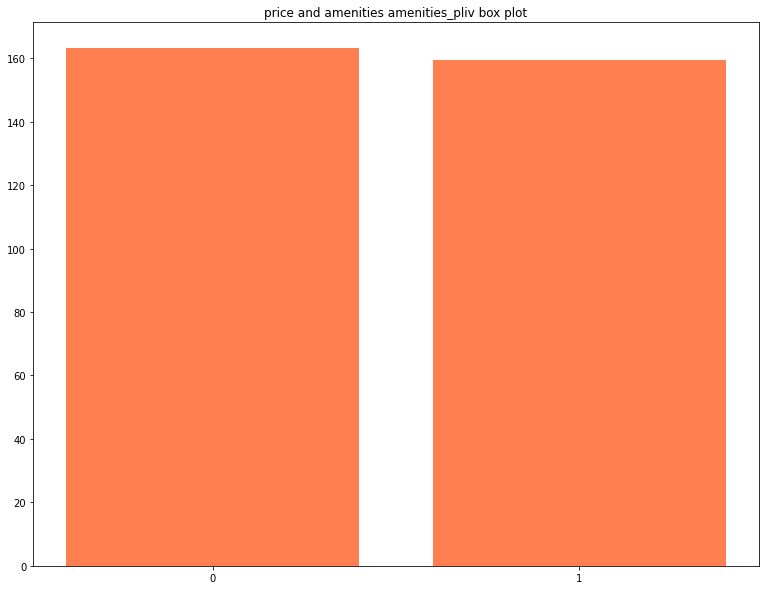

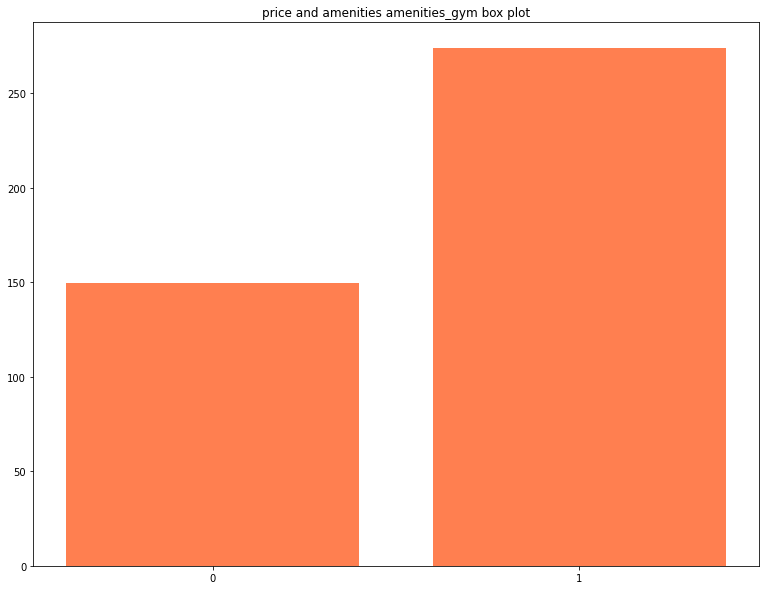

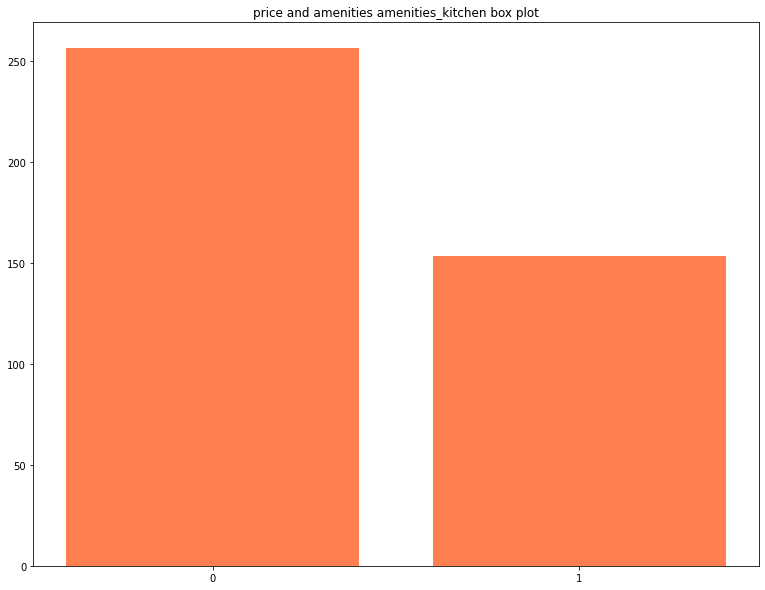

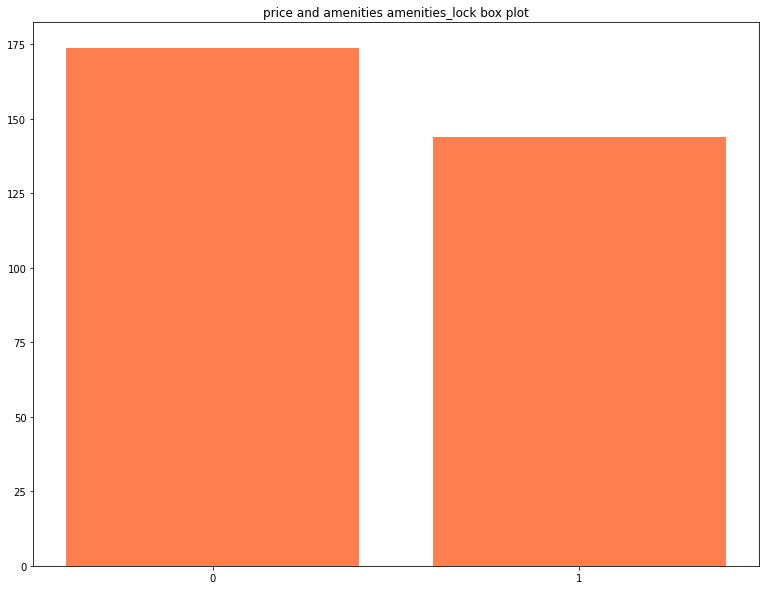

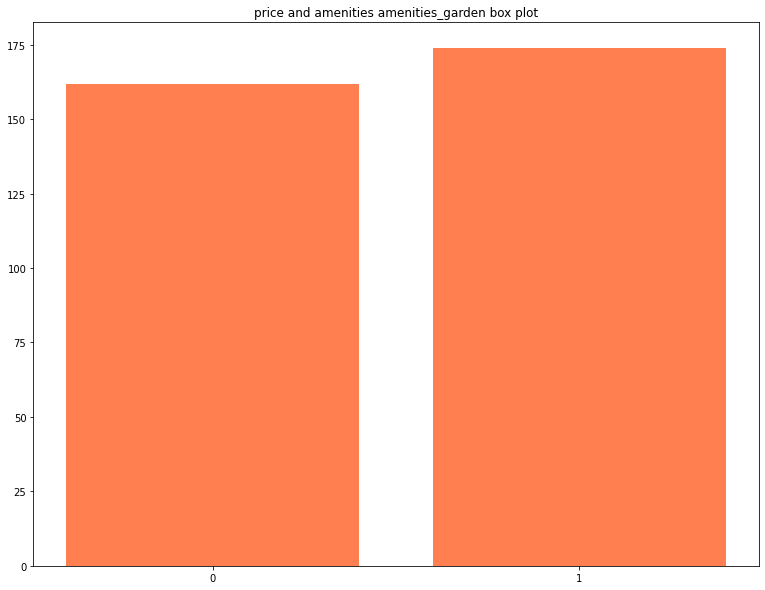

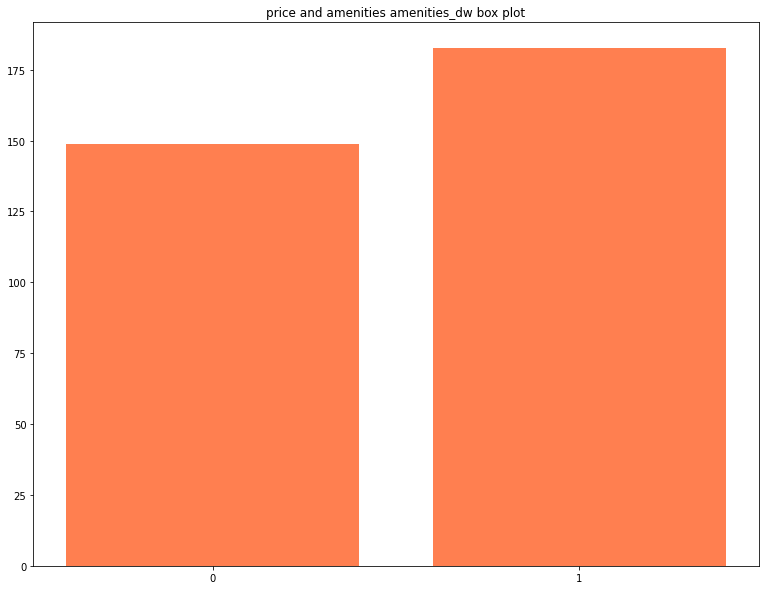

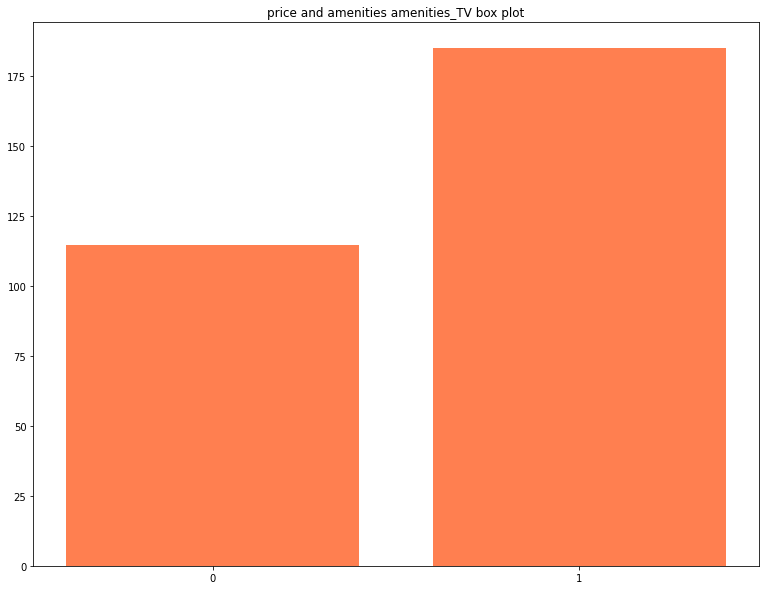

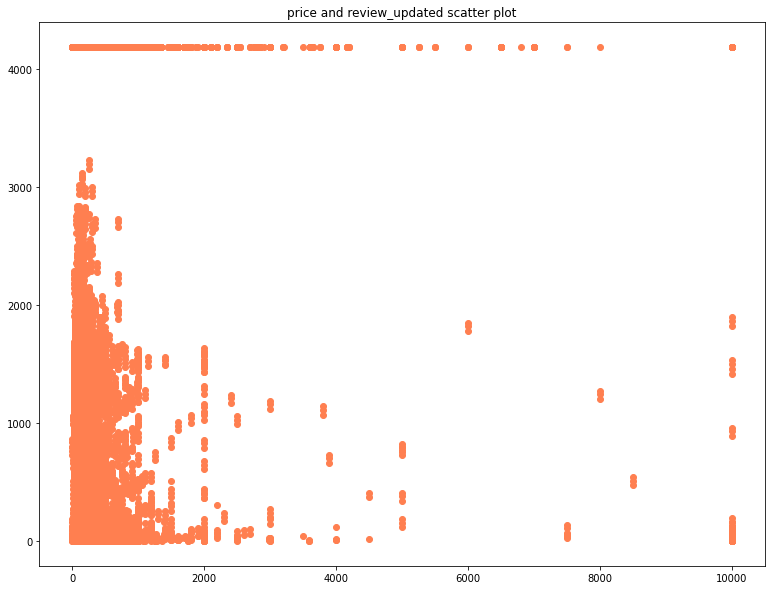

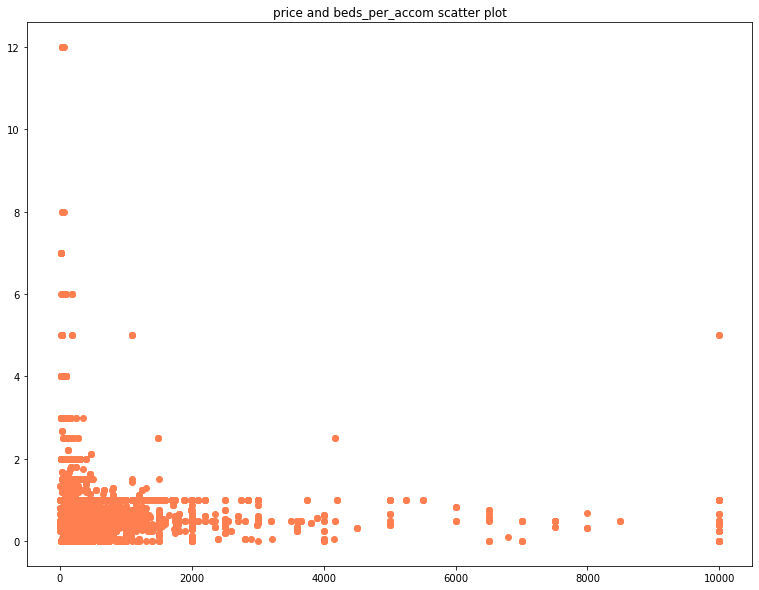

In [ ]:
 lst = ['amenities_24h',
 'amenities_bathtub',
 'amenities_breakfast',
 'amenities_pool',
 'amenities_pent',
 'amenities_pliv',
 'amenities_gym',
 'amenities_kitchen',
 'amenities_lock',
 'amenities_garden',
 'amenities_dw',
 'amenities_TV',
 'review_updated',
 'beds_per_accom']
 for i in lst :
    if 'amenities' in i :
      plt.figure(figsize=(13,10))
      plt.bar(x=["0",'1'], height = [data[data[i]==0]['price'].mean(), data[data[i]==1]['price'].mean()], color = 'coral')
      plt.title('price and amenities %s box plot'%(i))
      plt.show()
    else :
      plt.figure(figsize=(13,10))
      plt.scatter(data['price'], data[i], color = 'coral')
      plt.title('price and %s scatter plot'%(i))
      plt.show()

# Scaling and get_dummies

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ML/airbnb_preprocessed(updated).csv', encoding='utf-8')

In [ ]:
data

availability_30  availability_365  ... review_updated  beds_per_accom
0                    30               365  ...          100.0        1.000000
1                     0                42  ...         1500.0        0.250000
2                    30               180  ...          288.0        0.333333
3                    11               125  ...           93.0        1.000000
4                    20                86  ...            3.0        0.500000
...                 ...               ...  ...            ...             ...
153249                2                15  ...            1.0        0.666667
153250               15               250  ...            8.0        0.250000
153251               11               155  ...           17.0        0.666667
153252                7               131  ...            6.0        0.555556
153253                0                 8  ...          236.0        0.500000

[153254 rows x 36 columns]

In [ ]:
def scale_and_get_dum(df, is_train = False, scaler = None) :
    features_num = df.describe().columns.tolist()
    for i in features_num :
        if ('amenities' in i) or ('price' in i) or ('security' in i) :
            features_num.remove(i)
    df = pd.get_dummies(df, drop_first=True)
    features_dum = list(set(df.columns)-set(features_num))
    # train set일 때, scale
    if is_train :
        scaler_df = preprocessing.StandardScaler()
        df_scaled = scaler_df.fit_transform(df[features_num])
        df_scaled = pd.DataFrame(df_scaled, columns=features_num, index=df.index)
        df_scaled[features_dum] = df[features_dum]
        return df_scaled, scaler_df
    # val, test set 일 때, scale
    else :
        df_scaled = scaler.transform(df[features_num])
        df_scaled = pd.DataFrame(df_scaled, columns=features_num, index=df.index)
        df_scaled[features_dum] = df[features_dum]
        return df_scaled

In [ ]:
# training : validation : test = 6 : 2 : 2
train, test = train_test_split(data, test_size=0.4, random_state=1234)
val, test = train_test_split(test, test_size=0.5, random_state=1234)

# Robust Scaling
train_scaled, scaler = scale_and_get_dum(train, is_train=True)
val_scaled = scale_and_get_dum(val, scaler = scaler)
test_scaled = scale_and_get_dum(test, scaler = scaler)   

# x, y 분리
train_x, train_y = train_scaled.drop(['price'], axis=1), train['price']
val_x, val_y = val_scaled.drop(['price'], axis=1), val['price']
test_x, test_y = test_scaled.drop(['price'], axis=1), test['price']

# 각각의 shape 확인
print(train_x.shape, train_y.shape,'\n', val_x.shape, val_y.shape,'\n', test_x.shape, test_y.shape)

del train_scaled, val_scaled, test_scaled

(91952, 47) (91952,) 
 (30651, 47) (30651,) 
 (30651, 47) (30651,)


In [ ]:
data.describe()

availability_30  availability_365  ...  review_updated  beds_per_accom
count    153254.000000     153254.000000  ...   153254.000000   153254.000000
mean         10.696295        119.175434  ...     1098.314204        0.595496
std          12.161812        136.143870  ...     1610.517344        0.334941
min           0.000000          0.000000  ...        0.000000        0.000000
25%           0.000000          0.000000  ...       31.000000        0.500000
50%           3.000000         62.000000  ...      159.000000        0.500000
75%          24.000000        237.000000  ...     1335.000000        0.666667
max          30.000000        365.000000  ...     4191.000000       12.000000

[8 rows x 28 columns]

In [ ]:
train_x.describe()

availability_30  availability_365  ...  bed_type_Couch  amenities_lock
count     9.195200e+04      9.195200e+04  ...    91952.000000    91952.000000
mean      5.874528e-16     -1.025003e-15  ...        0.001164        0.372325
std       1.000005e+00      1.000005e+00  ...        0.034093        0.483427
min      -8.793871e-01     -8.766434e-01  ...        0.000000        0.000000
25%      -8.793871e-01     -8.766434e-01  ...        0.000000        0.000000
50%      -6.330735e-01     -4.208364e-01  ...        0.000000        0.000000
75%       1.091122e+00      8.657156e-01  ...        0.000000        1.000000
max       1.583749e+00      1.806736e+00  ...        1.000000        1.000000

[8 rows x 47 columns]

# Modeling1

In [ ]:
data['bed_type'].unique()

array(['Real Bed', 'Futon', 'Couch', 'Airbed', 'Pull-out Sofa'],
      dtype=object)

In [ ]:
data['neighbourhood_group_cleansed'].unique()

array(['Manhattan', 'Brooklyn', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [ ]:
data['property_type'].unique()

array(['housing', 'bph', 'other', 'bpl', 'se'], dtype=object)

In [ ]:
data['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [ ]:
sorted(train_x.columns.tolist())

['Crime_rate',
 'amenities_24h',
 'amenities_TV',
 'amenities_bathtub',
 'amenities_breakfast',
 'amenities_dw',
 'amenities_garden',
 'amenities_gym',
 'amenities_kitchen',
 'amenities_lock',
 'amenities_pent',
 'amenities_pliv',
 'amenities_pool',
 'availability_30',
 'availability_365',
 'bed_type_Couch',
 'bed_type_Futon',
 'bed_type_Pull-out Sofa',
 'bed_type_Real Bed',
 'bedrooms',
 'beds_per_accom',
 'calculated_host_listings_count',
 'cancellation_policy_moderate',
 'cancellation_policy_strict',
 'cleaning_fee',
 'extra_people',
 'host_identity_verified_t',
 'host_is_superhost_t',
 'host_response_time',
 'is_location_exact_t',
 'near_sub',
 'neighbourhood_group_cleansed_Brooklyn',
 'neighbourhood_group_cleansed_Manhattan',
 'neighbourhood_group_cleansed_Queens',
 'neighbourhood_group_cleansed_Staten Island',
 'number_of_reviews_ltm',
 'property_type_bpl',
 'property_type_housing',
 'property_type_other',
 'property_type_se',
 'review_scores_rating',
 'review_updated',
 'reviews

## linear regression

In [ ]:
lr = LinearRegression()
lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
lr.intercept_

285.329282683578

In [ ]:
lin_coeff = pd.DataFrame()
lin_coeff['var'] = train_x.columns
lin_coeff['coeff'] = lr.coef_
lin_coeff['abs_coeff'] = abs(lin_coeff['coeff'])
lin_coeff.sort_values(ascending = False, by = 'abs_coeff', inplace=True)
lin_coeff

var       coeff   abs_coeff
29                           property_type_bpl -247.084563  247.084563
46                        room_type_Hotel room -242.251117  242.251117
35                       property_type_housing -176.659622  176.659622
42                            property_type_se -164.383240  164.383240
44      neighbourhood_group_cleansed_Manhattan   97.864147   97.864147
31                         property_type_other  -83.322939   83.322939
40                       room_type_Shared room  -58.011586   58.011586
2                                     bedrooms   52.019058   52.019058
25       neighbourhood_group_cleansed_Brooklyn   46.297266   46.297266
22                               amenities_gym   44.208483   44.208483
32                      room_type_Private room  -41.423962   41.423962
21                              bed_type_Couch   36.234251   36.234251
45                  cancellation_policy_strict  -30.723207   30.723207
15                           amenities_kitchen  -30.383373   30.383373
11                                  Crime_rate   30.175709   30.175709
4                                 cleaning_fee   24.981203   24.981203
33         neighbourhood_group_cleansed_Queens   24.160718   24.160718
10                                    near_sub   22.897822   22.897822
34                cancellation_policy_moderate  -21.974685   21.974685
7                        number_of_reviews_ltm  -20.911371   20.911371
39                         amenities_breakfast   19.351467   19.351467
3               calculated_host_listings_count  -18.599173   18.599173
9                            reviews_per_month   17.105915   17.105915
1                             availability_365   15.948283   15.948283
18                              review_updated   14.557856   14.557856
38                              amenities_pent   12.244315   12.244315
27                           bed_type_Real Bed   12.228908   12.228908
0                              availability_30   11.747286   11.747286
17                                amenities_TV    8.198458    8.198458
6                           host_response_time   -7.673250    7.673250
23  neighbourhood_group_cleansed_Staten Island    6.829899    6.829899
19                              beds_per_accom   -6.408080    6.408080
26                                amenities_dw   -5.857802    5.857802
28                              bed_type_Futon   -5.081113    5.081113
13                              amenities_pool    4.297815    4.297815
8                         review_scores_rating   -4.124451    4.124451
43                               amenities_24h    4.049482    4.049482
14                              amenities_pliv   -3.392737    3.392737
12                           amenities_bathtub    2.545898    2.545898
16                            amenities_garden    2.538618    2.538618
37                            security_deposit    2.297398    2.297398
41                              amenities_lock   -2.142057    2.142057
20                         host_is_superhost_t   -1.872101    1.872101
36                    host_identity_verified_t    1.637158    1.637158
24                         is_location_exact_t   -1.596880    1.596880
5                                 extra_people    1.013004    1.013004
30                      bed_type_Pull-out Sofa   -0.155313    0.155313

In [ ]:
lr_pred = lr.predict(test_x)

#R^2
r2_lr = lr.score(test_x, test_y)

#RMSE
mse_lr_test = mean_squared_error(test_y, lr_pred)
rmse_lr_test = mse_lr_test**(0.5)

#MAE
mae_lr_test = mean_absolute_error(test_y, lr_pred)

In [ ]:
print('linear regression \nR-square : %.6f \nRMSE : %.6f \nMAE : %.6f'%(r2_lr, rmse_lr_test,mae_lr_test))

linear regression 
R-square : 0.107456 
RMSE : 433.416973 
MAE : 99.972189


## Decision Tree

In [ ]:
depth = pd.DataFrame({'max_depth': range(5,41,5)})
depth['key'] = 1
feature = pd.DataFrame({'max_features':range(5,41,5)})
feature['key'] = 1

In [ ]:
params = pd.merge(depth, feature, on ='key').drop("key", 1);params

In [ ]:
results = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])

for i in params.index :
  max_dep, max_feat = params.iloc[i]
  tree_reg = DecisionTreeRegressor( criterion='mse',max_depth=max_dep, max_features=max_feat, 
                                   min_samples_split=2, min_samples_leaf=1, random_state=1234)
  tree_reg.fit(train_x, train_y)
  tree_reg_pred_train = tree_reg.predict(train_x)
  tree_reg_pred_val = tree_reg.predict(val_x)
  tree_reg_r2 = r2_score(val_y, tree_reg_pred_val)
  mse_tree_reg_train = mean_squared_error(train_y, tree_reg_pred_train)
  rmse_tree_reg_train = mse_tree_reg_train**(0.5)
  mse_tree_reg_val = mean_squared_error(val_y, tree_reg_pred_val)
  rmse_tree_reg_val = mse_tree_reg_val**(0.5)
  mae_tree_reg_train = mean_absolute_error(train_y, tree_reg_pred_train)
  mae_tree_reg_val = mean_absolute_error(val_y, tree_reg_pred_val)
  hyper_params = 'max_depth : %s, max_features : %s '%(max_dep, max_feat)
  new_row = {'R2' : tree_reg_r2, 'RMSE(train)': rmse_tree_reg_train, 'RMSE(val)': rmse_tree_reg_val, 
             'MAE(train)': mae_tree_reg_train , 'MAE(val)' : mae_tree_reg_val, 'hyper_params' : hyper_params}
  results = results.append(new_row, ignore_index = True)

results

In [ ]:
difference = results["RMSE(val)"]-results["RMSE(train)"]

In [ ]:
results.loc[:,["RMSE(train)","RMSE(val)"]].plot()

In [ ]:
tree_reg = DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=40 ,
                                 min_samples_split=2, min_samples_leaf=1, random_state=1234)
tree_reg.fit(train_x, train_y)

In [ ]:
tree_reg_pred_test = tree_reg.predict(test_x)
mse_tree_reg_test = mean_squared_error(test_y, tree_reg_pred_test)
tree_reg_r2 = r2_score(test_y, tree_reg_pred_test)
mae_tree_reg_test=mean_absolute_error(test_y, tree_reg_pred_test)
print("R2:",tree_reg_r2)
print("RMSE:",mse_tree_reg_test**(0.5))
print("MAE:",mae_tree_reg_test )

## SVM Regressor

epsilon = 0.02

In [ ]:
from sklearn import svm
model_svm_rbf7=svm.SVR(kernel='rbf',C=30, epsilon=0.02)
model_svm_rbf7.fit(train_x,train_y)

In [ ]:
model_svm_rbf7_pred_train = model_svm_rbf7.predict(train_x)
model_svm_rbf7_pred_val = model_svm_rbf7.predict(val_x)

In [ ]:
#R2
model_svm_rbf7_r2 = model_svm_rbf7.score(val_x,val_y)
print("SVM_rbf7의 R2 (Val set): ",model_svm_rbf7_r2)
#RMSE
mse_model_svm_rbf7_train = mean_squared_error(train_y, model_svm_rbf7_pred_train)
rmse_model_svm_rbf7_train = mse_model_svm_rbf7_train**(0.5)
mse_model_svm_rbf7_val = mean_squared_error(val_y, model_svm_rbf7_pred_val)
rmse_model_svm_rbf7_val = mse_model_svm_rbf7_val**(0.5)
print("SVM_rbf7의 RMSE (Train set): ",rmse_model_svm_rbf7_train)
print("SVM_rbf7의 RMSE (Val set): ",rmse_model_svm_rbf7_val)
#MAE
mae_model_svm_rbf7_train = mean_absolute_error(train_y, model_svm_rbf7_pred_train)
mae_model_svm_rbf7_val = mean_absolute_error(val_y, model_svm_rbf7_pred_val)
print("SVM_rbf7의 MAE (Train set): ",mae_model_svm_rbf7_train)
print("SVM_rbf7의 MAE (Val set): ",mae_model_svm_rbf7_val)

In [ ]:
model_svm_rbf7.get_params

In [ ]:
model_svm_rbf8=svm.SVR(kernel='rbf',C=100, epsilon=0.02).fit(train_x,train_y)

In [ ]:
model_svm_rbf8_pred_train = model_svm_rbf8.predict(train_x)
model_svm_rbf8_pred_val = model_svm_rbf8.predict(val_x)

In [ ]:
#R2
model_svm_rbf8_r2 = model_svm_rbf8.score(val_x,val_y)
print("SVM_rbf8의 R2 (Val set): ",model_svm_rbf8_r2)
#RMSE
mse_model_svm_rbf8_train = mean_squared_error(train_y, model_svm_rbf8_pred_train)
rmse_model_svm_rbf8_train = mse_model_svm_rbf8_train**(0.5)
mse_model_svm_rbf8_val = mean_squared_error(val_y, model_svm_rbf8_pred_val)
rmse_model_svm_rbf8_val = mse_model_svm_rbf8_val**(0.5)
print("SVM_rbf8의 RMSE (Train set): ",rmse_model_svm_rbf8_train)
print("SVM_rbf8의 RMSE (Val set): ",rmse_model_svm_rbf8_val)
#MAE
mae_model_svm_rbf8_train = mean_absolute_error(train_y, model_svm_rbf8_pred_train)
mae_model_svm_rbf8_val = mean_absolute_error(val_y, model_svm_rbf8_pred_val)
print("SVM_rbf8의 MAE (Train set): ",mae_model_svm_rbf8_train)
print("SVM_rbf8의 MAE (Val set): ",mae_model_svm_rbf8_val)

In [ ]:
model_svm_rbf8.get_params

In [ ]:
model_svm_rbf9=svm.SVR(kernel='rbf',C=1, epsilon=0.02).fit(train_x,train_y)

In [ ]:
model_svm_rbf9_pred_train = model_svm_rbf9.predict(train_x)
model_svm_rbf9_pred_val = model_svm_rbf9.predict(val_x)

In [ ]:
#R2
model_svm_rbf9_r2 = model_svm_rbf9.score(val_x,val_y)
print("SVM_rbf9의 R2 (Val set): ",model_svm_rbf9_r2)
#RMSE
mse_model_svm_rbf9_train = mean_squared_error(train_y, model_svm_rbf9_pred_train)
rmse_model_svm_rbf9_train = mse_model_svm_rbf9_train**(0.5)
mse_model_svm_rbf9_val = mean_squared_error(val_y, model_svm_rbf9_pred_val)
rmse_model_svm_rbf9_val = mse_model_svm_rbf9_val**(0.5)
print("SVM_rbf9의 RMSE (Train set): ",rmse_model_svm_rbf9_train)
print("SVM_rbf9의 RMSE (Val set): ",rmse_model_svm_rbf9_val)
#MAE
mae_model_svm_rbf9_train = mean_absolute_error(train_y, model_svm_rbf9_pred_train)
mae_model_svm_rbf9_val = mean_absolute_error(val_y, model_svm_rbf9_pred_val)
print("SVM_rbf9의 MAE (Train set): ",mae_model_svm_rbf9_train)
print("SVM_rbf9의 MAE (Val set): ",mae_model_svm_rbf9_val)

In [ ]:
model_svm_rbf9=svm.SVR(kernel='rbf',C=10, epsilon=0.02).fit(train_x,train_y)

In [ ]:
model_svm_rbf9_pred_train = model_svm_rbf9.predict(train_x)
model_svm_rbf9_pred_val = model_svm_rbf9.predict(val_x)

In [ ]:
#R2
model_svm_rbf9_r2 = model_svm_rbf9.score(val_x,val_y)
print("SVM_rbf9의 R2 (Val set): ",model_svm_rbf9_r2)
#RMSE
mse_model_svm_rbf9_train = mean_squared_error(train_y, model_svm_rbf9_pred_train)
rmse_model_svm_rbf9_train = mse_model_svm_rbf9_train**(0.5)
mse_model_svm_rbf9_val = mean_squared_error(val_y, model_svm_rbf9_pred_val)
rmse_model_svm_rbf9_val = mse_model_svm_rbf9_val**(0.5)
print("SVM_rbf9의 RMSE (Train set): ",rmse_model_svm_rbf9_train)
print("SVM_rbf9의 RMSE (Val set): ",rmse_model_svm_rbf9_val)
#MAE
mae_model_svm_rbf9_train = mean_absolute_error(train_y, model_svm_rbf9_pred_train)
mae_model_svm_rbf9_val = mean_absolute_error(val_y, model_svm_rbf9_pred_val)
print("SVM_rbf9의 MAE (Train set): ",mae_model_svm_rbf9_train)
print("SVM_rbf9의 MAE (Val set): ",mae_model_svm_rbf9_val)

epsilon = 0.1

In [ ]:
model_svm_rbf7=svm.SVR(kernel='rbf',C=30, epsilon=0.1)
model_svm_rbf7.fit(train_x,train_y)

In [ ]:
model_svm_rbf7_pred_train = model_svm_rbf7.predict(train_x)
model_svm_rbf7_pred_val = model_svm_rbf7.predict(val_x)

In [ ]:
#R2
model_svm_rbf7_r2 = model_svm_rbf7.score(val_x,val_y)
print("SVM_rbf7의 R2 (Val set): ",model_svm_rbf7_r2)
#RMSE
mse_model_svm_rbf7_train = mean_squared_error(train_y, model_svm_rbf7_pred_train)
rmse_model_svm_rbf7_train = mse_model_svm_rbf7_train**(0.5)
mse_model_svm_rbf7_val = mean_squared_error(val_y, model_svm_rbf7_pred_val)
rmse_model_svm_rbf7_val = mse_model_svm_rbf7_val**(0.5)
print("SVM_rbf7의 RMSE (Train set): ",rmse_model_svm_rbf7_train)
print("SVM_rbf7의 RMSE (Val set): ",rmse_model_svm_rbf7_val)
#MAE
mae_model_svm_rbf7_train = mean_absolute_error(train_y, model_svm_rbf7_pred_train)
mae_model_svm_rbf7_val = mean_absolute_error(val_y, model_svm_rbf7_pred_val)
print("SVM_rbf7의 MAE (Train set): ",mae_model_svm_rbf7_train)
print("SVM_rbf7의 MAE (Val set): ",mae_model_svm_rbf7_val)

In [ ]:
model_svm_rbf7.get_params

In [ ]:
model_svm_rbf8=svm.SVR(kernel='rbf',C=100, epsilon=0.1).fit(train_x,train_y)

In [ ]:
model_svm_rbf8_pred_train = model_svm_rbf8.predict(train_x)
model_svm_rbf8_pred_val = model_svm_rbf8.predict(val_x)

In [ ]:
#R2
model_svm_rbf8_r2 = model_svm_rbf8.score(val_x,val_y)
print("SVM_rbf8의 R2 (Val set): ",model_svm_rbf8_r2)
#RMSE
mse_model_svm_rbf8_train = mean_squared_error(train_y, model_svm_rbf8_pred_train)
rmse_model_svm_rbf8_train = mse_model_svm_rbf8_train**(0.5)
mse_model_svm_rbf8_val = mean_squared_error(val_y, model_svm_rbf8_pred_val)
rmse_model_svm_rbf8_val = mse_model_svm_rbf8_val**(0.5)
print("SVM_rbf8의 RMSE (Train set): ",rmse_model_svm_rbf8_train)
print("SVM_rbf8의 RMSE (Val set): ",rmse_model_svm_rbf8_val)
#MAE
mae_model_svm_rbf8_train = mean_absolute_error(train_y, model_svm_rbf8_pred_train)
mae_model_svm_rbf8_val = mean_absolute_error(val_y, model_svm_rbf8_pred_val)
print("SVM_rbf8의 MAE (Train set): ",mae_model_svm_rbf8_train)
print("SVM_rbf8의 MAE (Val set): ",mae_model_svm_rbf8_val)

In [ ]:
model_svm_rbf8.get_params

In [ ]:
model_svm_rbf9=svm.SVR(kernel='rbf',C=1, epsilon=0.1).fit(train_x,train_y)

In [ ]:
model_svm_rbf9_pred_train = model_svm_rbf9.predict(train_x)
model_svm_rbf9_pred_val = model_svm_rbf9.predict(val_x)

In [ ]:
#R2
model_svm_rbf9_r2 = model_svm_rbf9.score(val_x,val_y)
print("SVM_rbf9의 R2 (Val set): ",model_svm_rbf9_r2)
#RMSE
mse_model_svm_rbf9_train = mean_squared_error(train_y, model_svm_rbf9_pred_train)
rmse_model_svm_rbf9_train = mse_model_svm_rbf9_train**(0.5)
mse_model_svm_rbf9_val = mean_squared_error(val_y, model_svm_rbf9_pred_val)
rmse_model_svm_rbf9_val = mse_model_svm_rbf9_val**(0.5)
print("SVM_rbf9의 RMSE (Train set): ",rmse_model_svm_rbf9_train)
print("SVM_rbf9의 RMSE (Val set): ",rmse_model_svm_rbf9_val)
#MAE
mae_model_svm_rbf9_train = mean_absolute_error(train_y, model_svm_rbf9_pred_train)
mae_model_svm_rbf9_val = mean_absolute_error(val_y, model_svm_rbf9_pred_val)
print("SVM_rbf9의 MAE (Train set): ",mae_model_svm_rbf9_train)
print("SVM_rbf9의 MAE (Val set): ",mae_model_svm_rbf9_val)

In [ ]:
model_svm_rbf9=svm.SVR(kernel='rbf',C=10, epsilon=0.1).fit(train_x,train_y)

In [ ]:
model_svm_rbf9_pred_train = model_svm_rbf9.predict(train_x)
model_svm_rbf9_pred_val = model_svm_rbf9.predict(val_x)

In [ ]:
#R2
model_svm_rbf9_r2 = model_svm_rbf9.score(val_x,val_y)
print("SVM_rbf9의 R2 (Val set): ",model_svm_rbf9_r2)
#RMSE
mse_model_svm_rbf9_train = mean_squared_error(train_y, model_svm_rbf9_pred_train)
rmse_model_svm_rbf9_train = mse_model_svm_rbf9_train**(0.5)
mse_model_svm_rbf9_val = mean_squared_error(val_y, model_svm_rbf9_pred_val)
rmse_model_svm_rbf9_val = mse_model_svm_rbf9_val**(0.5)
print("SVM_rbf9의 RMSE (Train set): ",rmse_model_svm_rbf9_train)
print("SVM_rbf9의 RMSE (Val set): ",rmse_model_svm_rbf9_val)
#MAE
mae_model_svm_rbf9_train = mean_absolute_error(train_y, model_svm_rbf9_pred_train)
mae_model_svm_rbf9_val = mean_absolute_error(val_y, model_svm_rbf9_pred_val)
print("SVM_rbf9의 MAE (Train set): ",mae_model_svm_rbf9_train)
print("SVM_rbf9의 MAE (Val set): ",mae_model_svm_rbf9_val)

## Random Forest

In [ ]:
rf_params = {'max_depth': [10, None], 'n_estimators': [50, 100, 200], 'min_samples_split' : [2, 5], 'min_samples_leaf' : [1,3,7], 'max_features' : [10,20,30]}
rf_p = list(product(*rf_params.values()))
rf_p

In [ ]:
rf_results = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
num=1
for i in rf_p : 
    try :
        max_dep = int(i[0])
    except :
        max_dep = i[0]
    n_est = int(i[1])
    min_split = int(i[2])
    min_leaf = int(i[3])
    max_f = int(i[4])
    rf = RandomForestRegressor(n_estimators= n_est, min_samples_split= min_split, max_depth = max_dep, 
                               min_samples_leaf = min_leaf, max_features = max_f, random_state=1234)
    rf.fit(train_x, train_y)
    rf_pred_train = rf.predict(train_x)
    rf_pred_val = rf.predict(val_x)
    rf_r2 = rf.score(val_x, val_y)
    mse_rf_train = mean_squared_error(train_y, rf_pred_train)
    rmse_rf_train = mse_rf_train**(0.5)
    mse_rf_val = mean_squared_error(val_y, rf_pred_val)
    rmse_rf_val = mse_rf_val**(0.5)
    mae_rf_train = mean_absolute_error(train_y, rf_pred_train)
    mae_rf_val = mean_absolute_error(val_y, rf_pred_val)
    hyper_params = 'n_est : %s,  min_split : %s'%(n_est, min_split)
    new_row = {'R2' : rf_r2, 'RMSE(train)': rmse_rf_train, 'RMSE(val)': rmse_rf_val, 
             'MAE(train)': mae_rf_train , 'MAE(val)' : mae_rf_val, 'hyper_params' : hyper_params}
    rf_results = rf_results.append(new_row, ignore_index = True)
    print(num)
    num+=1
rf_results

In [ ]:
rf_results = rf_results.sort_values('RMSE(val)', ascending=False).reset_index()
rf_results_sorted = rf_results.drop('index', axis=1)

In [ ]:
rf_results_sorted.loc[:,['RMSE(train)', 'RMSE(val)']].plot(figsize=(15,10))

In [ ]:
rf = RandomForestRegressor(n_estimators = 200, min_samples_split = 5, min_samples_leaf = 1, max_depth = None, max_features = 30, random_state=1234)
rf.fit(train_x,train_y)

rf_pred_test = rf.predict(test_x)

#R^2
r2_rf_test = rf.score(test_x, test_y)

#RMSE
mse_rf_test = mean_squared_error(test_y, rf_pred_test)
rmse_rf_test = np.sqrt(mse_rf_test)

#MAE
mae_rf_test = mean_absolute_error(test_y, rf_pred_test)

print('RandomForest regression(test) \nR-square : %.6f \nRMSE : %.6f \nMAE : %.6f'%(r2_rf_test, rmse_rf_test, mae_rf_test))

In [ ]:
rf_features = rf.feature_importances_
rf_features_imp = pd.Series(rf_features, index=train_x.columns)
rf_features_imp = rf_features_imp.sort_values(ascending=False)

plt.figure(figsize=(15,15))
plt.title('RF Boosting Feature Importances')
sns.barplot(x=rf_features_imp, y = rf_features_imp.index)
plt.show()

## Ada Boost

In [ ]:
ada_params = {'n_estimators': [25, 50, 100],'learning_rate' : [0.05,0.1,0.3], 'loss' : ['linear', 'square', 'exponential']}
ada_p = list(product(*ada_params.values()))
ada_p

[(25, 0.05, 'linear'),
 (25, 0.05, 'square'),
 (25, 0.05, 'exponential'),
 (25, 0.1, 'linear'),
 (25, 0.1, 'square'),
 (25, 0.1, 'exponential'),
 (25, 0.3, 'linear'),
 (25, 0.3, 'square'),
 (25, 0.3, 'exponential'),
 (50, 0.05, 'linear'),
 (50, 0.05, 'square'),
 (50, 0.05, 'exponential'),
 (50, 0.1, 'linear'),
 (50, 0.1, 'square'),
 (50, 0.1, 'exponential'),
 (50, 0.3, 'linear'),
 (50, 0.3, 'square'),
 (50, 0.3, 'exponential'),
 (100, 0.05, 'linear'),
 (100, 0.05, 'square'),
 (100, 0.05, 'exponential'),
 (100, 0.1, 'linear'),
 (100, 0.1, 'square'),
 (100, 0.1, 'exponential'),
 (100, 0.3, 'linear'),
 (100, 0.3, 'square'),
 (100, 0.3, 'exponential')]

In [ ]:
ada_results = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
num=1
for i in ada_p : 
  n_est = int(i[0])
  lr = float(i[1])
  los = i[2]
  ada = AdaBoostRegressor(learning_rate= lr, loss= los , n_estimators = n_est, random_state=1234)
  ada.fit(train_x, train_y)
  ada_pred_train = ada.predict(train_x)
  ada_pred_val = ada.predict(val_x)
  ada_r2 = ada.score(val_x, val_y)
  mse_ada_train = mean_squared_error(train_y, ada_pred_train)
  rmse_ada_train = mse_ada_train**(0.5)
  mse_ada_val = mean_squared_error(val_y, ada_pred_val)
  rmse_ada_val = mse_ada_val**(0.5)
  mae_ada_train = mean_absolute_error(train_y, ada_pred_train)
  mae_ada_val = mean_absolute_error(val_y, ada_pred_val)
  hyper_params = 'n_est : %s,  lr : %s, loss : %s'%(n_est, lr, los)
  new_row = {'R2' : ada_r2, 'RMSE(train)': rmse_ada_train, 'RMSE(val)': rmse_ada_val, 
             'MAE(train)': mae_ada_train , 'MAE(val)' : mae_ada_val, 'hyper_params' : hyper_params}
  ada_results = ada_results.append(new_row, ignore_index = True)
  print(num)
  num+=1
ada_results

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


R2  ...                                 hyper_params
0   0.151690  ...        n_est : 25,  lr : 0.05, loss : linear
1   0.011441  ...        n_est : 25,  lr : 0.05, loss : square
2   0.186668  ...   n_est : 25,  lr : 0.05, loss : exponential
3  -0.054818  ...         n_est : 25,  lr : 0.1, loss : linear
4  -0.738570  ...         n_est : 25,  lr : 0.1, loss : square
5   0.147619  ...    n_est : 25,  lr : 0.1, loss : exponential
6  -0.806297  ...         n_est : 25,  lr : 0.3, loss : linear
7  -1.659902  ...         n_est : 25,  lr : 0.3, loss : square
8  -0.389387  ...    n_est : 25,  lr : 0.3, loss : exponential
9  -0.028053  ...        n_est : 50,  lr : 0.05, loss : linear
10 -0.689014  ...        n_est : 50,  lr : 0.05, loss : square
11  0.156260  ...   n_est : 50,  lr : 0.05, loss : exponential
12 -0.469645  ...         n_est : 50,  lr : 0.1, loss : linear
13 -1.610931  ...         n_est : 50,  lr : 0.1, loss : square
14 -0.149213  ...    n_est : 50,  lr : 0.1, loss : exponential
15 -1.035656  ...         n_est : 50,  lr : 0.3, loss : linear
16 -2.588611  ...         n_est : 50,  lr : 0.3, loss : square
17 -1.129594  ...    n_est : 50,  lr : 0.3, loss : exponential
18 -0.385316  ...       n_est : 100,  lr : 0.05, loss : linear
19 -1.599062  ...       n_est : 100,  lr : 0.05, loss : square
20 -0.134291  ...  n_est : 100,  lr : 0.05, loss : exponential
21 -0.826836  ...        n_est : 100,  lr : 0.1, loss : linear
22 -2.380262  ...        n_est : 100,  lr : 0.1, loss : square
23 -0.655803  ...   n_est : 100,  lr : 0.1, loss : exponential
24 -1.035656  ...        n_est : 100,  lr : 0.3, loss : linear
25 -2.588611  ...        n_est : 100,  lr : 0.3, loss : square
26 -2.568317  ...   n_est : 100,  lr : 0.3, loss : exponential

[27 rows x 6 columns]

In [ ]:
ada_results = ada_results.sort_values('RMSE(val)', ascending=False).reset_index()
ada_results_sorted = ada_results.drop('index', axis=1)

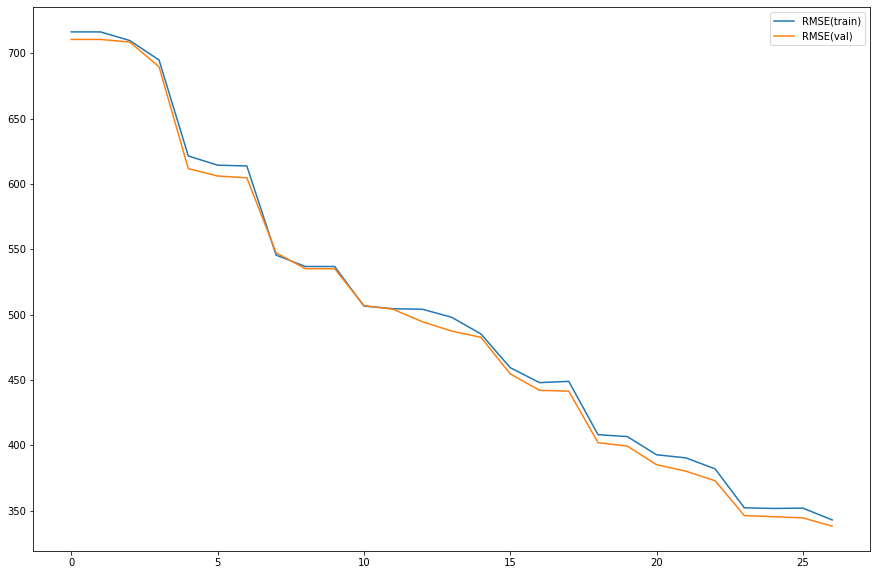

In [ ]:
ada_results_sorted.loc[:,['RMSE(train)', 'RMSE(val)']].plot(figsize=(15,10))

In [ ]:
ada_results_sorted.iloc[20:]

R2  ...                                hyper_params
20 -0.054818  ...        n_est : 25,  lr : 0.1, loss : linear
21 -0.028053  ...       n_est : 50,  lr : 0.05, loss : linear
22  0.011441  ...       n_est : 25,  lr : 0.05, loss : square
23  0.147619  ...   n_est : 25,  lr : 0.1, loss : exponential
24  0.151690  ...       n_est : 25,  lr : 0.05, loss : linear
25  0.156260  ...  n_est : 50,  lr : 0.05, loss : exponential
26  0.186668  ...  n_est : 25,  lr : 0.05, loss : exponential

[7 rows x 6 columns]

In [ ]:
ada = AdaBoostRegressor(learning_rate =  0.05, loss =  'exponential', n_estimators = 25, random_state=1234)

In [ ]:
ada.fit(train_x, train_y)

# R^2
ada_pred = ada.predict(test_x)                                     
ada_r2 = ada.score(test_x, test_y)
ada_r2

0.32182395508012784

In [ ]:
#RMSE
mse_ada_test = mean_squared_error(test_y, ada_pred)
rmse_ada_test = mse_ada_test**(0.5)
rmse_ada_test

377.80028941930783

In [ ]:
#MAE
mae_ada_test = mean_absolute_error(test_y, ada_pred)
mae_ada_test

102.70834406711559

In [ ]:
ada.feature_importances_

array([0.        , 0.        , 0.0707932 , 0.03439268, 0.03855561,
       0.00091845, 0.        , 0.00267589, 0.        , 0.        ,
       0.04504051, 0.13046192, 0.        , 0.        , 0.        ,
       0.20437348, 0.        , 0.        , 0.        , 0.00932734,
       0.01031325, 0.        , 0.        , 0.        , 0.        ,
       0.29607075, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00129856, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.15577838,
       0.        , 0.        ])

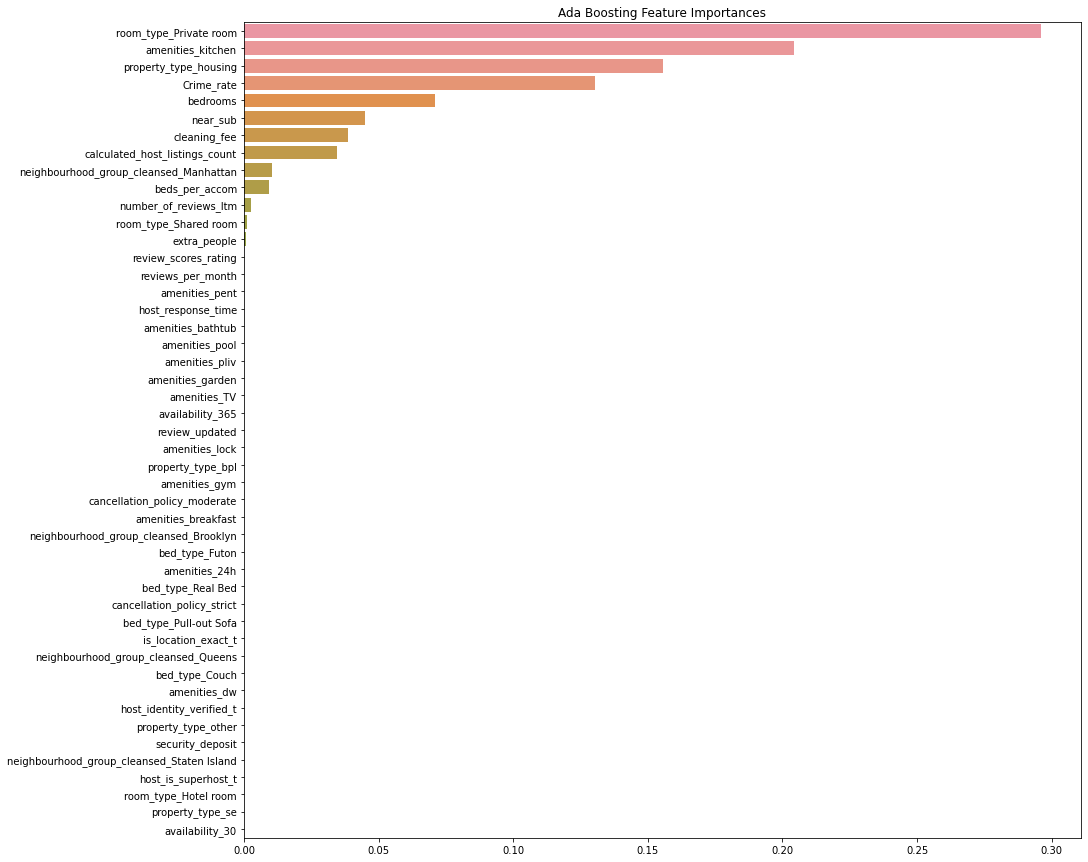

In [ ]:
ada_features = ada.feature_importances_
ada_feature_imp = pd.Series(ada_features, index=train_x.columns)
ada_feature_imp = ada_feature_imp.sort_values(ascending=False)

plt.figure(figsize=(15,15))
plt.title('Ada Boosting Feature Importances')
sns.barplot(x=ada_feature_imp, y = ada_feature_imp.index)
plt.show()

## Gradient Boosting

In [ ]:
gb_parmas = {'learning_rate': [0.01,0.05,0.3,0.5], 'n_estimators': [50, 100, 150],'max_depth': [3, 5, 7]}
gb_p = list(product(*gb_parmas.values()))
gb_p

[(0.01, 50, 3),
 (0.01, 50, 5),
 (0.01, 50, 7),
 (0.01, 100, 3),
 (0.01, 100, 5),
 (0.01, 100, 7),
 (0.01, 150, 3),
 (0.01, 150, 5),
 (0.01, 150, 7),
 (0.05, 50, 3),
 (0.05, 50, 5),
 (0.05, 50, 7),
 (0.05, 100, 3),
 (0.05, 100, 5),
 (0.05, 100, 7),
 (0.05, 150, 3),
 (0.05, 150, 5),
 (0.05, 150, 7),
 (0.3, 50, 3),
 (0.3, 50, 5),
 (0.3, 50, 7),
 (0.3, 100, 3),
 (0.3, 100, 5),
 (0.3, 100, 7),
 (0.3, 150, 3),
 (0.3, 150, 5),
 (0.3, 150, 7),
 (0.5, 50, 3),
 (0.5, 50, 5),
 (0.5, 50, 7),
 (0.5, 100, 3),
 (0.5, 100, 5),
 (0.5, 100, 7),
 (0.5, 150, 3),
 (0.5, 150, 5),
 (0.5, 150, 7)]

In [ ]:
gb_results = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
num=1
for i in gb_p : 
  lr = float(i[0])
  n_est = int(i[1])
  max_d = i[2]
  gb = GradientBoostingRegressor(learning_rate= lr, max_depth= max_d , n_estimators = n_est, random_state = 1234)
  gb.fit(train_x, train_y)
  gb_pred_train = gb.predict(train_x)
  gb_pred_val = gb.predict(val_x)
  gb_r2 = gb.score(val_x, val_y)
  mse_gb_train = mean_squared_error(train_y, gb_pred_train)
  rmse_gb_train = mse_gb_train**(0.5)
  mse_gb_val = mean_squared_error(val_y, gb_pred_val)
  rmse_gb_val = mse_gb_val**(0.5)
  mae_gb_train = mean_absolute_error(train_y, gb_pred_train)
  mae_gb_val = mean_absolute_error(val_y, gb_pred_val)
  hyper_params = 'n_est : %s,  lr : %s, max_depth : %s'%(n_est, lr, max_d)
  new_row = {'R2' : gb_r2, 'RMSE(train)': rmse_gb_train, 'RMSE(val)': rmse_gb_val, 
             'MAE(train)': mae_gb_train , 'MAE(val)' : mae_gb_val, 'hyper_params' : hyper_params}
  gb_results = gb_results.append(new_row, ignore_index = True)
  print(num)
  num+=1
gb_results

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


R2  RMSE(train)  ...   MAE(val)                            hyper_params
0   0.083089   369.203338  ...  90.419979   n_est : 50,  lr : 0.01, max_depth : 3
1   0.201877   338.056636  ...  86.308306   n_est : 50,  lr : 0.01, max_depth : 5
2   0.319543   303.521647  ...  83.167015   n_est : 50,  lr : 0.01, max_depth : 7
3   0.121195   359.925893  ...  83.440880  n_est : 100,  lr : 0.01, max_depth : 3
4   0.293421   310.510752  ...  77.833299  n_est : 100,  lr : 0.01, max_depth : 5
5   0.456386   254.476990  ...  72.789338  n_est : 100,  lr : 0.01, max_depth : 7
6   0.147857   353.205957  ...  79.931964  n_est : 150,  lr : 0.01, max_depth : 3
7   0.345898   292.663786  ...  73.143904  n_est : 150,  lr : 0.01, max_depth : 5
8   0.525573   226.097572  ...  66.893149  n_est : 150,  lr : 0.01, max_depth : 7
9   0.177360   344.293489  ...  76.828243   n_est : 50,  lr : 0.05, max_depth : 3
10  0.428305   269.642196  ...  68.695940   n_est : 50,  lr : 0.05, max_depth : 5
11  0.582315   192.763061  ...  61.479131   n_est : 50,  lr : 0.05, max_depth : 7
12  0.223604   327.955988  ...  74.426579  n_est : 100,  lr : 0.05, max_depth : 3
13  0.479991   245.773450  ...  65.348076  n_est : 100,  lr : 0.05, max_depth : 5
14  0.640882   159.876927  ...  57.139985  n_est : 100,  lr : 0.05, max_depth : 7
15  0.240809   320.794714  ...  74.039667  n_est : 150,  lr : 0.05, max_depth : 3
16  0.506385   227.805909  ...  64.209690  n_est : 150,  lr : 0.05, max_depth : 5
17  0.663407   143.293772  ...  55.902725  n_est : 150,  lr : 0.05, max_depth : 7
18  0.273793   300.274794  ...  76.037464    n_est : 50,  lr : 0.3, max_depth : 3
19  0.537180   209.221624  ...  65.687052    n_est : 50,  lr : 0.3, max_depth : 5
20  0.690550   118.095390  ...  56.809325    n_est : 50,  lr : 0.3, max_depth : 7
21  0.347486   276.862513  ...  76.888951   n_est : 100,  lr : 0.3, max_depth : 3
22  0.607019   166.857568  ...  63.731821   n_est : 100,  lr : 0.3, max_depth : 5
23  0.724259    85.203717  ...  55.248177   n_est : 100,  lr : 0.3, max_depth : 7
24  0.365419   268.467200  ...  76.434421   n_est : 150,  lr : 0.3, max_depth : 3
25  0.624288   149.638018  ...  63.486933   n_est : 150,  lr : 0.3, max_depth : 5
26  0.733468    72.543693  ...  53.991639   n_est : 150,  lr : 0.3, max_depth : 7
27  0.314408   283.574807  ...  79.259470    n_est : 50,  lr : 0.5, max_depth : 3
28  0.523051   188.669730  ...  68.744739    n_est : 50,  lr : 0.5, max_depth : 5
29  0.652135    93.158467  ...  58.916886    n_est : 50,  lr : 0.5, max_depth : 7
30  0.340615   268.763016  ...  79.621156   n_est : 100,  lr : 0.5, max_depth : 3
31  0.559446   153.123545  ...  67.440573   n_est : 100,  lr : 0.5, max_depth : 5
32  0.664158    70.967581  ...  57.852660   n_est : 100,  lr : 0.5, max_depth : 7
33  0.379781   257.234138  ...  80.041972   n_est : 150,  lr : 0.5, max_depth : 3
34  0.580233   134.248149  ...  66.643667   n_est : 150,  lr : 0.5, max_depth : 5
35  0.672965    57.986817  ...  56.536968   n_est : 150,  lr : 0.5, max_depth : 7

[36 rows x 6 columns]

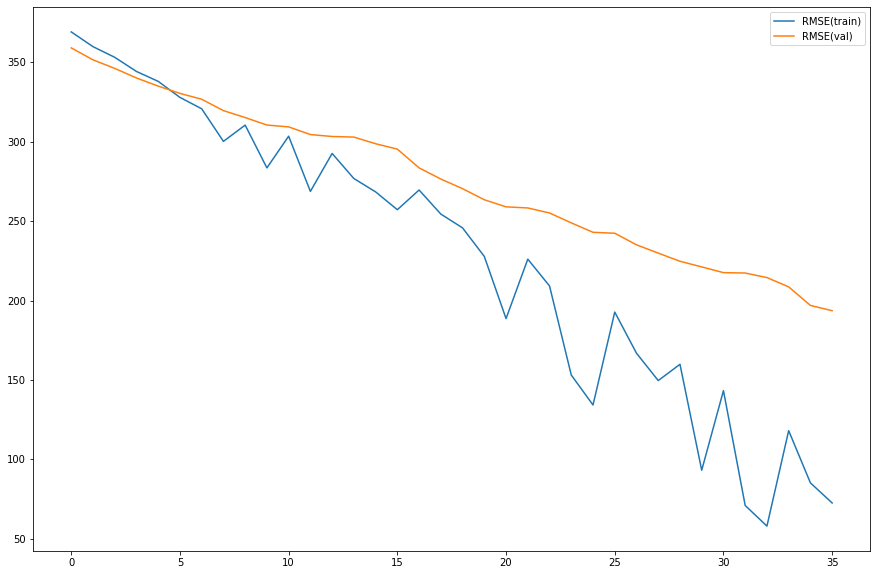

In [ ]:
gb_results = gb_results.sort_values('RMSE(val)', ascending=False).reset_index()
gb_results_sorted = gb_results.drop('index', axis=1)
gb_results_sorted.loc[:,['RMSE(train)', 'RMSE(val)']].plot(figsize=(15,10))

In [ ]:
gb_results_sorted.iloc[20:]

R2  RMSE(train)  ...   MAE(val)                            hyper_params
20  0.523051   188.669730  ...  68.744739    n_est : 50,  lr : 0.5, max_depth : 5
21  0.525573   226.097572  ...  66.893149  n_est : 150,  lr : 0.01, max_depth : 7
22  0.537180   209.221624  ...  65.687052    n_est : 50,  lr : 0.3, max_depth : 5
23  0.559446   153.123545  ...  67.440573   n_est : 100,  lr : 0.5, max_depth : 5
24  0.580233   134.248149  ...  66.643667   n_est : 150,  lr : 0.5, max_depth : 5
25  0.582315   192.763061  ...  61.479131   n_est : 50,  lr : 0.05, max_depth : 7
26  0.607019   166.857568  ...  63.731821   n_est : 100,  lr : 0.3, max_depth : 5
27  0.624288   149.638018  ...  63.486933   n_est : 150,  lr : 0.3, max_depth : 5
28  0.640882   159.876927  ...  57.139985  n_est : 100,  lr : 0.05, max_depth : 7
29  0.652135    93.158467  ...  58.916886    n_est : 50,  lr : 0.5, max_depth : 7
30  0.663407   143.293772  ...  55.902725  n_est : 150,  lr : 0.05, max_depth : 7
31  0.664158    70.967581  ...  57.852660   n_est : 100,  lr : 0.5, max_depth : 7
32  0.672965    57.986817  ...  56.536968   n_est : 150,  lr : 0.5, max_depth : 7
33  0.690550   118.095390  ...  56.809325    n_est : 50,  lr : 0.3, max_depth : 7
34  0.724259    85.203717  ...  55.248177   n_est : 100,  lr : 0.3, max_depth : 7
35  0.733468    72.543693  ...  53.991639   n_est : 150,  lr : 0.3, max_depth : 7

[16 rows x 6 columns]

In [ ]:
gb = GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, max_depth=7)
gb.fit(train_x, train_y)

# R^2
gb_pred = gb.predict(test_x)                                     
gb_r2 = gb.score(test_x, test_y)
gb_r2

0.7602225568824992

In [ ]:
#RMSE
mse_gb_test = mean_squared_error(test_y, gb_pred)
rmse_gb_test = mse_gb_test**(0.5)
rmse_gb_test

224.64420820361534

In [ ]:
#MAE
mae_gb_test = mean_absolute_error(test_y, gb_pred)
mae_gb_test

57.51958606230882

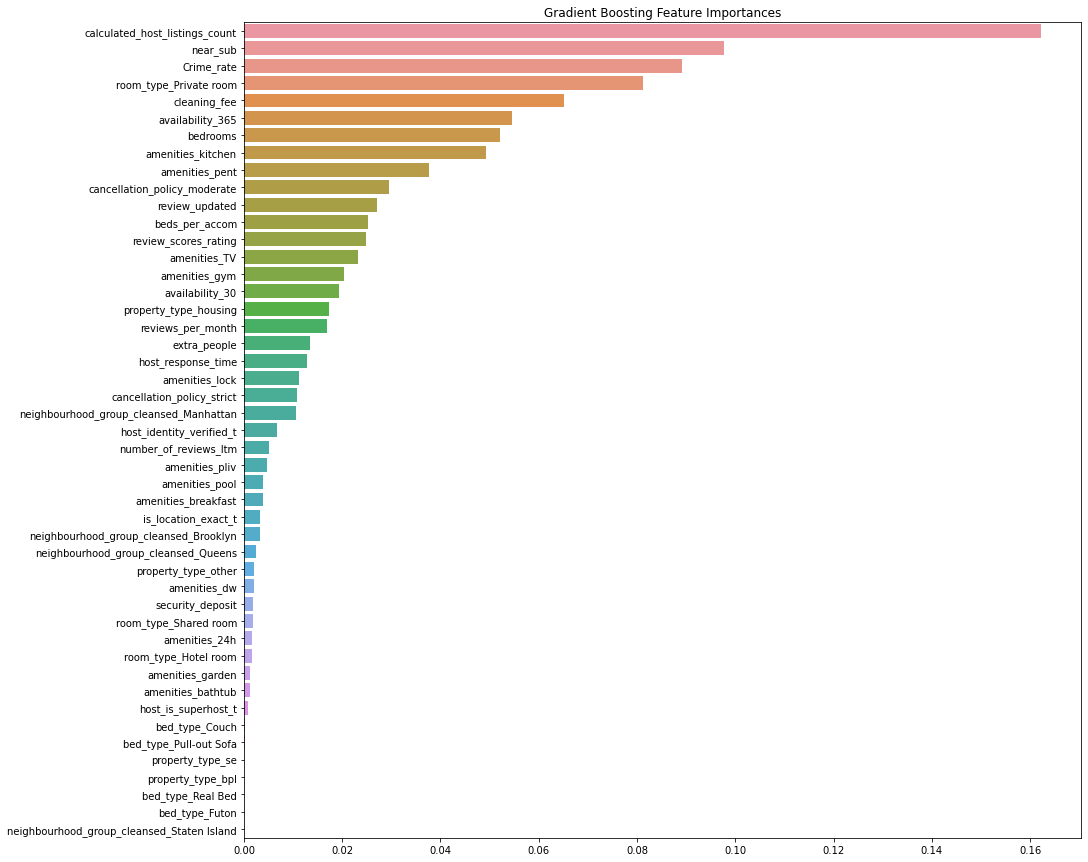

In [ ]:
gb_features = gb.feature_importances_
gb_feature_imp = pd.Series(gb_features, index=train_x.columns)
gb_feature_imp = gb_feature_imp.sort_values(ascending=False)

plt.figure(figsize=(15,15))
plt.title('Gradient Boosting Feature Importances')
sns.barplot(x=gb_feature_imp, y = gb_feature_imp.index)
plt.show()

## XG-Boost

In [ ]:
params = pd.read_csv('/content/drive/MyDrive/ML/realparams.csv')
results = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
for i in params.index :
  n_est, min_c_w, max_dep, lr = params.iloc[i]
  n_est, min_c_w, max_dep = int(n_est), int(min_c_w), int(max_dep)
  xgb = XGBRegressor(n_estimators=n_est, min_child_weight=min_c_w, max_depth=max_dep, learning_rate=lr, n_jobs=-1,  random_state= 1234, objective = 'reg:squarederror')
  xgb.fit(train_x, train_y)
  xgb_pred_train = xgb.predict(train_x)
  xgb_pred_val = xgb.predict(val_x)
  xgb_r2 = xgb.score(val_x, val_y)
  mse_xgb_train = mean_squared_error(train_y, xgb_pred_train)
  rmse_xgb_train = mse_xgb_train**(0.5)
  mse_xgb_val = mean_squared_error(val_y, xgb_pred_val)
  rmse_xgb_val = mse_xgb_val**(0.5)
  mae_xgb_train = mean_absolute_error(train_y, xgb_pred_train)
  mae_xgb_val = mean_absolute_error(val_y, xgb_pred_val)
  hyper_params = 'n_est : %s, min_c_w : %s, max_d : %s, lr : %s'%(n_est, min_c_w, max_dep, lr)
  new_row = {'R2' : xgb_r2, 'RMSE(train)': rmse_xgb_train, 'RMSE(val)': rmse_xgb_val, 
             'MAE(train)': mae_xgb_train , 'MAE(val)' : mae_xgb_val, 'hyper_params' : hyper_params}
  results = results.append(new_row, ignore_index = True)
  print(i)
results

최적 하이퍼 파라미터 적용

In [ ]:
xgb = XGBRegressor(n_estimators=500, min_child_weight=5, max_depth=7, learning_rate=0.01, 
                               n_jobs=-1, random_state= 1234, objective = 'reg:squarederror')
xgb.fit(test_x, test_y)

In [ ]:
xgb_pred_test = xgb.predict(test_x)
r2 = xgb.score(test_x, test_y)
r2

In [ ]:
#RMSE_test
mse_xgb_test = mean_squared_error(test_y, xgb_pred_test)
rmse_xgb_test = mse_xgb_test**(0.5)
#MAE_test
mae_xgb_test = mean_absolute_error(test_y, xgb_pred_test)
print(rmse_xgb_test)
print(mae_xgb_test)

In [ ]:
gb_features = gb.feature_importances_
gb_feature_imp = pd.Series(gb_features, index=train_x.columns)
gb_feature_imp = gb_feature_imp.sort_values(ascending=False)

plt.figure(figsize=(15,15))
plt.title('Gradient Boosting Feature Importances')
sns.barplot(x=gb_feature_imp, y = gb_feature_imp.index)
plt.show()

# Modeling 2 (log변환)

In [ ]:
data['price'] = np.log(data['price']+1)
data['price'].describe()

In [ ]:
plt.figure(figsize=(10,10))
sns.distplot(data['price'], rug=True)
plt.title("Normal Price Distribution Plot",size=15, weight='bold')

In [ ]:
def scale_and_get_dum(df, is_train = False, scaler = None) :
    features_num = df.describe().columns.tolist()
    for i in features_num :
        if ('amenities' in i) or ('price' in i) or ('security' in i) :
            features_num.remove(i)
    df = pd.get_dummies(df, drop_first=True)
    features_dum = list(set(df.columns)-set(features_num))
    # train set일 때, scale
    if is_train :
        scaler_df = preprocessing.StandardScaler()
        df_scaled = scaler_df.fit_transform(df[features_num])
        df_scaled = pd.DataFrame(df_scaled, columns=features_num, index=df.index)
        df_scaled[features_dum] = df[features_dum]
        return df_scaled, scaler_df
    # val, test set 일 때, scale
    else :
        df_scaled = scaler.transform(df[features_num])
        df_scaled = pd.DataFrame(df_scaled, columns=features_num, index=df.index)
        df_scaled[features_dum] = df[features_dum]
        return df_scaled

In [ ]:
# training : validation : test = 6 : 2 : 2
train, test = train_test_split(data, test_size=0.4, random_state=1234)
val, test = train_test_split(test, test_size=0.5, random_state=1234)

# Robust Scaling
train_scaled, scaler = scale_and_get_dum(train, is_train=True)
val_scaled = scale_and_get_dum(val, scaler = scaler)
test_scaled = scale_and_get_dum(test, scaler = scaler)   

# x, y 분리
train_x, train_y = train_scaled.drop(['price'], axis=1), train['price']
val_x, val_y = val_scaled.drop(['price'], axis=1), val['price']
test_x, test_y = test_scaled.drop(['price'], axis=1), test['price']

# 각각의 shape 확인
print(train_x.shape, train_y.shape,'\n', val_x.shape, val_y.shape,'\n', test_x.shape, test_y.shape)

del train_scaled, val_scaled, test_scaled

## linear regression

In [ ]:
lr = LinearRegression()
lr.fit(train_x, train_y)
lr.intercept_

In [ ]:
lin_coeff = pd.DataFrame()
lin_coeff['var'] = train_x.columns
lin_coeff['coeff'] = lr.coef_
lin_coeff['abs_coeff'] = abs(lin_coeff['coeff'])
lin_coeff.sort_values(ascending = False, by = 'abs_coeff', inplace=True)
lin_coeff

In [ ]:
lr_pred = lr.predict(test_x)

#R^2
r2_lr = lr.score(test_x, test_y)

#RMSE
mse_lr_test = mean_squared_error(test_y, lr_pred)
rmse_lr_test = mse_lr_test**(0.5)

#MAE
mae_lr_test = mean_absolute_error(test_y, lr_pred)
print('linear regression \nR-square : %.6f \nRMSE : %.6f \nMAE : %.6f'%(r2_lr, rmse_lr_test,mae_lr_test))

## Decision Tree

In [ ]:
depth = pd.DataFrame({'max_depth': range(5,41,5)})
depth['key'] = 1
feature = pd.DataFrame({'max_features':range(5,41,5)})
feature['key'] = 1
params = pd.merge(depth, feature, on ='key').drop("key", 1)
results = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])

for i in params.index :
  max_dep, max_feat = params.iloc[i]
  tree_reg = DecisionTreeRegressor( criterion='mse',max_depth=max_dep, max_features=max_feat, 
                                   min_samples_split=2, min_samples_leaf=1, random_state=1234)
  tree_reg.fit(train_x, train_y)
  tree_reg_pred_train = tree_reg.predict(train_x)
  tree_reg_pred_val = tree_reg.predict(val_x)
  tree_reg_r2 = r2_score(val_y, tree_reg_pred_val)
  mse_tree_reg_train = mean_squared_error(train_y, tree_reg_pred_train)
  rmse_tree_reg_train = mse_tree_reg_train**(0.5)
  mse_tree_reg_val = mean_squared_error(val_y, tree_reg_pred_val)
  rmse_tree_reg_val = mse_tree_reg_val**(0.5)
  mae_tree_reg_train = mean_absolute_error(train_y, tree_reg_pred_train)
  mae_tree_reg_val = mean_absolute_error(val_y, tree_reg_pred_val)
  hyper_params = 'max_depth : %s, max_features : %s '%(max_dep, max_feat)
  new_row = {'R2' : tree_reg_r2, 'RMSE(train)': rmse_tree_reg_train, 'RMSE(val)': rmse_tree_reg_val, 
             'MAE(train)': mae_tree_reg_train , 'MAE(val)' : mae_tree_reg_val, 'hyper_params' : hyper_params}
  results = results.append(new_row, ignore_index = True)

results

In [ ]:
difference = results["RMSE(val)"]-results["RMSE(train)"]
results.loc[:,["RMSE(train)","RMSE(val)"]].plot()
tree_reg = DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=40 ,
                                 min_samples_split=2, min_samples_leaf=1, random_state=1234)
tree_reg.fit(train_x, train_y)
tree_reg_pred_test = tree_reg.predict(test_x)
mse_tree_reg_test = mean_squared_error(test_y, tree_reg_pred_test)
tree_reg_r2 = r2_score(test_y, tree_reg_pred_test)
mae_tree_reg_test=mean_absolute_error(test_y, tree_reg_pred_test)
print("R2:",tree_reg_r2)
print("RMSE:",mse_tree_reg_test**(0.5))
print("MAE:",mae_tree_reg_test )

## Random Forest

In [ ]:
rf_results = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
num=1
for i in rf_p : 
    try :
        max_dep = int(i[0])
    except :
        max_dep = i[0]
    n_est = int(i[1])
    min_split = int(i[2])
    min_leaf = int(i[3])
    max_f = int(i[4])
    rf = RandomForestRegressor(n_estimators= n_est, min_samples_split= min_split, max_depth = max_dep, 
                               min_samples_leaf = min_leaf, max_features = max_f, random_state=1234)
    rf.fit(train_x, train_y)
    rf_pred_train = rf.predict(train_x)
    rf_pred_val = rf.predict(val_x)
    rf_r2 = rf.score(val_x, val_y)
    mse_rf_train = mean_squared_error(train_y, rf_pred_train)
    rmse_rf_train = mse_rf_train**(0.5)
    mse_rf_val = mean_squared_error(val_y, rf_pred_val)
    rmse_rf_val = mse_rf_val**(0.5)
    mae_rf_train = mean_absolute_error(train_y, rf_pred_train)
    mae_rf_val = mean_absolute_error(val_y, rf_pred_val)
    hyper_params = 'n_est : %s,  min_split : %s'%(n_est, min_split)
    new_row = {'R2' : rf_r2, 'RMSE(train)': rmse_rf_train, 'RMSE(val)': rmse_rf_val, 
             'MAE(train)': mae_rf_train , 'MAE(val)' : mae_rf_val, 'hyper_params' : hyper_params}
    rf_results = rf_results.append(new_row, ignore_index = True)
    print(num)
    num+=1
rf_results

In [ ]:
rf_results = rf_results.sort_values('RMSE(val)', ascending=False).reset_index()
rf_results_sorted = rf_results.drop('index', axis=1)
rf_results_sorted.loc[:,['RMSE(train)', 'RMSE(val)']].plot(figsize=(15,10))

rf = RandomForestRegressor(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 1, max_depth = None, max_features = 20, random_state=1234)
rf.fit(train_x,train_y)

rf_pred_test = rf.predict(test_x)

#R^2
r2_rf_test = rf.score(test_x, test_y)

#RMSE
mse_rf_test = mean_squared_error(test_y, rf_pred_test)
rmse_rf_test = np.sqrt(mse_rf_test)

#MAE
mae_rf_test = mean_absolute_error(test_y, rf_pred_test)

print('RandomForest regression(test) \nR-square : %.6f \nRMSE : %.6f \nMAE : %.6f'%(r2_rf_test, rmse_rf_test, mae_rf_test))

In [ ]:
rf_features = rf.feature_importances_
rf_features_imp = pd.Series(rf_features, index=train_x.columns)
rf_features_imp = rf_features_imp.sort_values(ascending=False)

plt.figure(figsize=(15,15))
plt.title('RF Boosting Feature Importances')
sns.barplot(x=rf_features_imp, y = rf_features_imp.index)
plt.show()

## Ada Boost

In [ ]:
ada_params = {'n_estimators': [25, 50, 100],'learning_rate' : [0.05,0.1,0.3], 'loss' : ['linear', 'square', 'exponential']}
ada_p = list(product(*ada_params.values()))
ada_results = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
num=1
for i in ada_p : 
  n_est = int(i[0])
  lr = float(i[1])
  los = i[2]
  ada = AdaBoostRegressor(learning_rate= lr, loss= los , n_estimators = n_est, random_state=1234)
  ada.fit(train_x, train_y)
  ada_pred_train = ada.predict(train_x)
  ada_pred_val = ada.predict(val_x)
  ada_r2 = ada.score(val_x, val_y)
  mse_ada_train = mean_squared_error(train_y, ada_pred_train)
  rmse_ada_train = mse_ada_train**(0.5)
  mse_ada_val = mean_squared_error(val_y, ada_pred_val)
  rmse_ada_val = mse_ada_val**(0.5)
  mae_ada_train = mean_absolute_error(train_y, ada_pred_train)
  mae_ada_val = mean_absolute_error(val_y, ada_pred_val)
  hyper_params = 'n_est : %s,  lr : %s, loss : %s'%(n_est, lr, los)
  new_row = {'R2' : ada_r2, 'RMSE(train)': rmse_ada_train, 'RMSE(val)': rmse_ada_val, 
             'MAE(train)': mae_ada_train , 'MAE(val)' : mae_ada_val, 'hyper_params' : hyper_params}
  ada_results = ada_results.append(new_row, ignore_index = True)
  print(num)
  num+=1
ada_results



In [ ]:
ada_results = ada_results.sort_values('RMSE(val)', ascending=False).reset_index()
ada_results_sorted = ada_results.drop('index', axis=1)

ada_results_sorted.loc[:,['RMSE(train)', 'RMSE(val)']].plot(figsize=(15,10))

In [ ]:
ada = AdaBoostRegressor(learning_rate =  0.05, loss =  'exponential', n_estimators = 100, random_state=1234)
ada.fit(train_x, train_y)

# R^2
ada_pred = ada.predict(test_x)                                     
ada_r2 = ada.score(test_x, test_y)

#RMSE
mse_ada_test = mean_squared_error(test_y, ada_pred)
rmse_ada_test = mse_ada_test**(0.5)

#MAE
mae_ada_test = mean_absolute_error(test_y, ada_pred)

print('R2 : %s, RMSE : %s : MAE : %s'%(ada_r2, rmse_ada_test_, mae_ada_test))

In [ ]:
ada_features = ada.feature_importances_
ada_feature_imp = pd.Series(ada_features, index=train_x.columns)
ada_feature_imp = ada_feature_imp.sort_values(ascending=False)

plt.figure(figsize=(15,15))
plt.title('Ada Boosting Feature Importances')
sns.barplot(x=ada_feature_imp, y = ada_feature_imp.index)
plt.show()

## Gradient Boosting

In [ ]:
gb_parmas = {'learning_rate': [0.01,0.05,0.3,0.5], 'n_estimators': [50, 100, 150],'max_depth': [3, 5, 7]}
gb_p = list(product(*gb_parmas.values()))

gb_results = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
num=1
for i in gb_p : 
  lr = float(i[0])
  n_est = int(i[1])
  max_d = i[2]
  gb = GradientBoostingRegressor(learning_rate= lr, max_depth= max_d , n_estimators = n_est, random_state = 1234)
  gb.fit(train_x, train_y)
  gb_pred_train = gb.predict(train_x)
  gb_pred_val = gb.predict(val_x)
  gb_r2 = gb.score(val_x, val_y)
  mse_gb_train = mean_squared_error(train_y, gb_pred_train)
  rmse_gb_train = mse_gb_train**(0.5)
  mse_gb_val = mean_squared_error(val_y, gb_pred_val)
  rmse_gb_val = mse_gb_val**(0.5)
  mae_gb_train = mean_absolute_error(train_y, gb_pred_train)
  mae_gb_val = mean_absolute_error(val_y, gb_pred_val)
  hyper_params = 'n_est : %s,  lr : %s, max_depth : %s'%(n_est, lr, max_d)
  new_row = {'R2' : gb_r2, 'RMSE(train)': rmse_gb_train, 'RMSE(val)': rmse_gb_val, 
             'MAE(train)': mae_gb_train , 'MAE(val)' : mae_gb_val, 'hyper_params' : hyper_params}
  gb_results = gb_results.append(new_row, ignore_index = True)
  print(num)
  num+=1
gb_results

gb_results = gb_results.sort_values('RMSE(val)', ascending=False).reset_index()
gb_results_sorted = gb_results.drop('index', axis=1)
gb_results_sorted.loc[:,['RMSE(train)', 'RMSE(val)']].plot(figsize=(15,10))

gb = GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, max_depth=7)
gb.fit(train_x, train_y)



In [ ]:
# R^2
gb_pred = gb.predict(test_x)                                     
gb_r2 = gb.score(test_x, test_y)

#RMSE
mse_gb_test = mean_squared_error(test_y, gb_pred)
rmse_gb_test = mse_gb_test**(0.5)


#MAE
mae_gb_test = mean_absolute_error(test_y, gb_pred)

print('R2 : %s, RMSE : %s, MAE : %s'%(gb_r2, rmse_gb_test, mae_gb_test))

In [ ]:
gb_features = gb.feature_importances_
gb_feature_imp = pd.Series(gb_features, index=train_x.columns)
gb_feature_imp = gb_feature_imp.sort_values(ascending=False)

plt.figure(figsize=(15,15))
plt.title('Gradient Boosting Feature Importances')
sns.barplot(x=gb_feature_imp, y = gb_feature_imp.index)
plt.show()

## XG-Boost

In [ ]:
params = pd.read_csv('/content/drive/MyDrive/ML/realparams.csv')
results = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','hyper_params'])
for i in params.index :
  n_est, min_c_w, max_dep, lr = params.iloc[i]
  n_est, min_c_w, max_dep = int(n_est), int(min_c_w), int(max_dep)
  xgb = XGBRegressor(n_estimators=n_est, min_child_weight=min_c_w, max_depth=max_dep, learning_rate=lr, n_jobs=-1,  random_state= 1234, objective = 'reg:squarederror')
  xgb.fit(train_x, train_y)
  xgb_pred_train = xgb.predict(train_x)
  xgb_pred_val = xgb.predict(val_x)
  xgb_r2 = xgb.score(val_x, val_y)
  mse_xgb_train = mean_squared_error(train_y, xgb_pred_train)
  rmse_xgb_train = mse_xgb_train**(0.5)
  mse_xgb_val = mean_squared_error(val_y, xgb_pred_val)
  rmse_xgb_val = mse_xgb_val**(0.5)
  mae_xgb_train = mean_absolute_error(train_y, xgb_pred_train)
  mae_xgb_val = mean_absolute_error(val_y, xgb_pred_val)
  hyper_params = 'n_est : %s, min_c_w : %s, max_d : %s, lr : %s'%(n_est, min_c_w, max_dep, lr)
  new_row = {'R2' : xgb_r2, 'RMSE(train)': rmse_xgb_train, 'RMSE(val)': rmse_xgb_val, 
             'MAE(train)': mae_xgb_train , 'MAE(val)' : mae_xgb_val, 'hyper_params' : hyper_params}
  results = results.append(new_row, ignore_index = True)
  print(i)
results

In [ ]:
xgb = XGBRegressor(n_estimators=500, min_child_weight=5, max_depth=7, learning_rate=0.01, 
                               n_jobs=-1, random_state= 1234, objective = 'reg:squarederror')
xgb.fit(test_x, test_y)

xgb_pred_test = xgb.predict(test_x)
r2 = xgb.score(test_x, test_y)
r2

#RMSE_test
mse_xgb_test = mean_squared_error(test_y, xgb_pred_test)
rmse_xgb_test = mse_xgb_test**(0.5)
#MAE_test
mae_xgb_test = mean_absolute_error(test_y, xgb_pred_test)
print('r-square', r2)
print('rmse', rmse_xgb_test)
print('mae', mae_xgb_test)

In [ ]:
gb_features = gb.feature_importances_
gb_feature_imp = pd.Series(gb_features, index=train_x.columns)
gb_feature_imp = gb_feature_imp.sort_values(ascending=False)

plt.figure(figsize=(15,15))
plt.title('Gradient Boosting Feature Importances')
sns.barplot(x=gb_feature_imp, y = gb_feature_imp.index)
plt.show()

# 부록 PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()
pca.fit_transform(train_x)
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum

In [ ]:
plt.figure(figsize=(15,7))
explained_variance_ratio = pca.explained_variance_ratio_
x_axis = range(1, len(explained_variance_ratio)+1)
plt.bar(x_axis, explained_variance_ratio,
        align = 'center', label = 'Individual Explained Variance Ratio')
plt.step(x_axis, np.cumsum(explained_variance_ratio),
          where = 'mid', color='red', label='Cumulative Explained Variance Ratio')
plt.plot([0.80]*55, color = 'gray')
plt.plot([0.99]*55, color = 'gray')
plt.ylim(0, 1.1)
plt.xticks(x_axis, fontsize = 12)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()

In [ ]:
results = pd.DataFrame(columns = ['R2','RMSE(train)','RMSE(val)','MAE(train)','MAE(val)','n_components'])
num=1
for i in range(13,37) :
  pca = PCA(n_components=i)
  pca.fit(train_x)
  reduced_train_x = pca.transform(train_x)
  reduced_val_x = pca.transform(val_x)
  lr = LinearRegression(fit_intercept=True)
  lr.fit(reduced_train_x, train_y)
  lr_pred_train = lr.predict(reduced_train_x)
  lr_pred_val = lr.predict(reduced_val_x)
  lr_r2 = lr.score(reduced_val_x, val_y)
  mse_lr_train = mean_squared_error(train_y, lr_pred_train)
  rmse_lr_train = mse_lr_train**(0.5)
  mse_lr_val = mean_squared_error(val_y, lr_pred_val)
  rmse_lr_val = mse_lr_val**(0.5)
  mae_lr_train = mean_absolute_error(train_y, lr_pred_train)
  mae_lr_val = mean_absolute_error(val_y, lr_pred_val)
  new_row = {'R2' : lr_r2, 'RMSE(train)': rmse_lr_train, 'RMSE(val)': rmse_lr_val, 
             'MAE(train)': mae_lr_train , 'MAE(val)' : mae_lr_val, 'n_components' : i}
  results = results.append(new_row, ignore_index = True)
  print(num)
  num+=1
results

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(results['n_components'], results['R2'], label='R2')
plt.plot(results['n_components'], results['RMSE(train)'], label='RMSE(train)')
plt.plot(results['n_components'], results['RMSE(val)'], label='RMSE(val)')
plt.xticks(results['n_components'], fontsize = 12)
plt.legend()

In [ ]:
pca = PCA(n_components = 22)
pca.fit(train_x)
reduced_train_x = pca.transform(train_x)
reduced_train_x.shape

In [ ]:
cols= ['PC'+str(i) for i in range(1, 23)]
reduced_train_x = pd.DataFrame(reduced_train_x, columns=cols)
reduced_train_x

In [ ]:
reduced_test_x = pca.transform(test_x)
reduced_test_x = pd.DataFrame(reduced_test_x, columns=cols)
reduced_test_x

In [ ]:
lr = LinearRegression(fit_intercept=True)
lr.fit(reduced_train_x, train_y)
print(lr.intercept_)

In [ ]:
lin_coeff = pd.DataFrame()
lin_coeff['var'] = reduced_train_x.columns
lin_coeff['coeff'] = lr.coef_
lin_coeff['abs_coeff'] = abs(lin_coeff['coeff'])
lin_coeff.sort_values(ascending = False, by = 'abs_coeff', inplace=True)
lin_coeff

In [ ]:
lr_pred = lr.predict(reduced_test_x)

#R^2
r2_lr = lr.score(reduced_test_x, test_y)

#RMSE
mse_lr_test = mean_squared_error(test_y, lr_pred)
rmse_lr_test = mse_lr_test**(0.5)

#MAE
mae_lr_test = mean_absolute_error(test_y, lr_pred)

In [ ]:
print('linear regression \nR-square : %.6f \nRMSE : %.6f \nMAE : %.6f'%(r2_lr, rmse_lr_test,mae_lr_test))